# Homework 3
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right?

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [13]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.3.0+cu100
# CUDA enabled: True

Version 1.3.1+cu100
CUDA enabled: True


In [14]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
'My Drive'


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to navigate to the BASE_PATH directory and upload the homework2.tar file inside the BASE_PATH, then extract it.



In [0]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/homework3/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')

In [0]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util
import math

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [17]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
        # TODO Add more preprocessing
    # one way to replace the wired space with blank
    # data = data.replace('\n',' ')
    # data = data.replace('\t',' ')
    # data = data.replace('\x1f',' ')
    # another way to replace the wired sapce with blank
    data = " ".join(data.split())
    voc2ind = {}
    counter = 0 # to give the index of the different key in the voc2ind dictionary

    # Compute voc2ind and transform the data into an integer representation of the tokens.
    for char in data:
        # TODO Fill this in
        if char not in voc2ind:
          voc2ind[char] = counter
          counter = counter + 1
    print(voc2ind)

    ind2voc = {val: key for key, val in voc2ind.items()}
    
    #divid the data in two 0.8 and 0.2
    train_index = int(0.8 * len(data))
    train_text = data[:train_index] #start to the train_index
    test_text = data[train_index:] #0.8 to the end

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

{'H': 0, 'a': 1, 'r': 2, 'y': 3, ' ': 4, 'P': 5, 'o': 6, 't': 7, 'e': 8, 'n': 9, 'd': 10, 'h': 11, 'S': 12, 'c': 13, "'": 14, 's': 15, 'C': 16, 'A': 17, 'T': 18, 'E': 19, 'R': 20, 'O': 21, 'N': 22, 'B': 23, 'Y': 24, 'W': 25, 'L': 26, 'I': 27, 'V': 28, 'D': 29, 'M': 30, '.': 31, 'u': 32, 'l': 33, ',': 34, 'f': 35, 'm': 36, 'b': 37, 'i': 38, 'v': 39, 'w': 40, 'p': 41, 'k': 42, 'x': 43, 'g': 44, 'j': 45, 'G': 46, ';': 47, '-': 48, '"': 49, 'F': 50, 'z': 51, '?': 52, '!': 53, 'q': 54, 'K': 55, '(': 56, ')': 57, ':': 58, 'J': 59, 'U': 60, '4': 61, '1': 62, '7': 63, 'Z': 64, '3': 65, 'Q': 66, '~': 67, '0': 68, '2': 69, '8': 70, 'X': 71, '9': 72, '5': 73, '*': 74, '6': 75, '\\': 76, '/': 77, '`': 78, '_': 79, '=': 80, '$': 81, '%': 82, ']': 83, '&': 84, '}': 85, '^': 86, '{': 87, '[': 88}


#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [0]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        self.voc2ind = dataset['voc2ind']
        self.ind2voc = dataset['ind2voc']
        # print(self.ind2voc)
        # print(self.voc2ind)
        self.tokens = dataset['tokens']
        # print(self.tokens)
        en_tokens = []
        for item in self.tokens:
          en_tokens.append(self.voc2ind[item])
        #print(len(en_taken))
        data=torch.LongTensor(en_tokens[:len(en_tokens)-(len(en_tokens)%batch_size)])
        self.data = data.view(batch_size, -1)
        cal_batch_squence = (self.data.shape[1]-1)/self.sequence_length
        self.batch_squence = math.ceil(cal_batch_squence)

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
         return  self.batch_squence * self.data.shape[0]
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        # data = self.data[batch_index][start_index: min(self.data.shape[1], start_index + self.sequence_length + 1)]
        # find the betch index
        batch_index = idx % self.batch_size
        # find the squence index
        sequence_index = idx // self.batch_size
        # where to start
        start_index = sequence_index * self.sequence_length
        end_index = min(start_index + self.sequence_length + 1, self.data.shape[1])
        data = self.data[batch_index][start_index : end_index]
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [0]:
TEMPERATURE = 1

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, num_layers=1, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)
        
        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)
        #pt_util.restore(self, file_path)


#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [0]:
TEMPERATURE = 1
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        #raise NotImplementedError
        # max_output = output[0].argmax()
        max_output = output[0].argmax()
        outputs.append(max_output)
        #update model
        output, hidden = model.inference(max_output,hidden)
        #print('i am the max',outputs)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        #raise NotImplementedError
        #sample_output = torch.multinomial(output[0],1)[0]
        sample_output = torch.multinomial(output[0],1)[0]
        outputs.append(sample_output)
        #update model
        output, hidden = model.inference(sample_output,hidden,temperature=TEMPERATURE)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    # 1. Initialize the beam list with the single existing empty beam
    beam = [([], output, hidden, 0)]
    # TODO
    #raise NotImplementedError
    # 2. Repeat for the sequence length:
    for ii in range(sequence_length):
      #     1. For each beam in the beam list:
      new_beam = []
      for item in range(len(beam)):
        current = beam[item]
        # with replacement sample
        # all_sample = torch.multinomial(output[0], beam_width, replacement=False)
        # print('i am output len',len(current[1][0]),len(current[1]))
        all_samples = torch.multinomial(current[1][0], beam_width, replacement=True)
        for sample in all_samples:
          single_sample = sample
          # Compute its score
          old_sample_score = current[1][0][single_sample]
          new_sample_score =  torch.log(old_sample_score) + current[3]
          # Record its hidden state and chosen value
          output, hidden = model.inference(single_sample, current[2], temperature=TEMPERATURE)
          # Add all the samples to the new beam list  
          beam_add = ([current[0] + [single_sample], output, hidden, new_sample_score])
          new_beam.append(beam_add)
      #Rank the new beam list by c4
      new_beam.sort(key=lambda val: val[3], reverse=True)
      # only use the beam_wiidth =10 
      #beam = new_beam[0:beam_width]
      beam = new_beam[:beam_width]
    #Return the top beam's chosen values. beam[0][0]
    outputs = beam[0][0]
    #print('i am the beam outputs ',beam[0][0])
    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)
            #print('return',vocab.array_to_words(outputs))

        #print("generate_language",vocab.array_to_words(seed_words_arr.tolist() + outputs))
        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [0]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_loss = np.mean(losses)
    train_prep = np.exp(train_loss)

    return np.mean(losses) , train_prep


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            # if batch_idx % 10 == 0:
            #     print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
            #         test_loader.dataset.vocab.array_to_words(data[0]),
            #         test_loader.dataset.vocab.array_to_words(label[0]),
            #         test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_prep = np.exp(test_loss)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    #print('\n test prep', test_prep)
    return test_loss, test_accuracy , test_prep

Using device cuda
num workers: 2
test load 12544 49920


  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 17.3598, Accuracy: 8134/1254400 (1%)



  1%|          | 2/195 [00:00<00:41,  4.69it/s]

Train Epoch: 0 [0/49920 (0%)]	Loss: 17.252134


100%|██████████| 195/195 [00:30<00:00,  6.45it/s]



Test set: Average loss: 1.9974, Accuracy: 589074/1254400 (47%)

Saved /content/checkpoints/000.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "You the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. The gotint the wooks out toud the the the exched tomeon. Hfeed themen to the curror with all off thestur becaush the the tostured toke. "Profeesor McGing!" "Well, keyell, I dememed to be out telll," s
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Thelp the his ehough ever hold tor beall, Harry, "Umbredore stard hooll way voice ever yourst wo boys out to the mostrefor the looks that thought the for hist tenadas too. Ballos? Thoough them though
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry sturned to the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the



  1%|          | 2/195 [00:00<00:49,  3.91it/s]

Train Epoch: 1 [0/49920 (0%)]	Loss: 1.975655


100%|██████████| 195/195 [00:30<00:00,  6.39it/s]



Test set: Average loss: 1.6468, Accuracy: 656011/1254400 (52%)

Saved /content/checkpoints/001.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What he said the stopped in the side of the straing to the floor and and the stopped in the side of the straing to the floor and and the stopped in the side of the straing to the floor and and the st
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Tow at the missrou," said Ron, hough at Harry, Moodyls snoud of all With Prhefecy in the shotue clarprid. "Muggle on, eno, soloppider passion and teant, looking took to the comment, did Foll smoudley
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Snatly find hear th, but he left you.... he knew brut mover which behor furming or chough time]!" "Yeah, like to looks to later what some the pine," said Harrys, working down, their switch. "You know 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The should he started to the stopped in the side of the straing to the floor and the stopped in the side of the straing to the floor and the stopped in the side of the straing to the floor and the sto



  1%|          | 2/195 [00:00<00:49,  3.90it/s]

Train Epoch: 2 [0/49920 (0%)]	Loss: 1.629212


100%|██████████| 195/195 [00:30<00:00,  6.38it/s]



Test set: Average loss: 1.5378, Accuracy: 688022/1254400 (55%)

Saved /content/checkpoints/002.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What did you the first the floor beside the trunk of the floor beside the trunk of the complant and the table to the floor beside the treement of the more boys little and looked and a look and a look
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. I'g !" back on the fing?" asked Madamion, brouth they cassinging up and and mairs behind as Siriust Fudge not be was right. Harry coure sitts of shill in quickly into coup entraally. The burroom a sit
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Bey's ill got uneal to god up Harry, all canging, drivitail sollow you arrvaintly, Beelapsion had tracked in a him because of thems lot the bottogrida you ever iside is breather in his rccog, so deen
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The trans of the come of the complant and the other and she was so long be all the floor beside the trunk of the floor behind him and the street of the floor beside the trunk of the floor beside the t



  1%|          | 2/195 [00:00<00:50,  3.85it/s]

Train Epoch: 3 [0/49920 (0%)]	Loss: 1.522938


100%|██████████| 195/195 [00:30<00:00,  6.37it/s]



Test set: Average loss: 1.5097, Accuracy: 697201/1254400 (56%)

Saved /content/checkpoints/003.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I should have been the for the floor beside the stretched of the strange of the floor beside the stretched of the side of the strange of the floor behind him and the stread of the strange of the stra
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Ron up the everyone taborun. He'd bed if point the Gryffingry part Rigwn in very sickly. Harry paint look that the wall taking or pircurlation was trout, in nothur pinc. The burs you, Quinter come all
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Mr. Potter. I'm sowl brought use if Harry fell out of the school of Munchant. Harry was a loger - bottun Mungustry's happoe, that number going to ok at did not Ron and famelt import. So plealebort, si
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry stretched and his wand a large and the stretched of the parchment and the start of the picked on the floor behind him and the stread of the strange of the picked on the floor behind him and the 



  1%|          | 2/195 [00:00<00:48,  3.96it/s]

Train Epoch: 4 [0/49920 (0%)]	Loss: 1.493286


100%|██████████| 195/195 [00:30<00:00,  6.39it/s]



Test set: Average loss: 1.4582, Accuracy: 710354/1254400 (57%)

Saved /content/checkpoints/004.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I should have been to be able to the for the first time to the for the first time to the first time to the first time to the first time to the first time to the first time to the first time to the fi
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Moold hear voices foree his ribridiec of it. "And you see in o, Hark," but seemed to how to me's humber, heading that shried emerved Hagrid heaver hakwave a mount Harry hand talking Harry thre staffer
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. lakee the ideagely, whot was slight or eye's weakly that Hall eyes just as must girls coping animale," said Professor Mr. (: severust his the are cold know Incee up from time his became at Creast, swi
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The train the table to the first to the first to the completely to the first to the first to the completely to the first to the first to the first to the completely to the first to the first to the fi



  1%|          | 2/195 [00:00<00:49,  3.90it/s]

Train Epoch: 5 [0/49920 (0%)]	Loss: 1.445524


100%|██████████| 195/195 [00:30<00:00,  6.44it/s]



Test set: Average loss: 1.4385, Accuracy: 715542/1254400 (57%)

Saved /content/checkpoints/005.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What do you were the only were the only were the only were the only were the only were the only were so the tree of the common room when the street of the completely to the for the for the for the fo
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. He told tell him dorming in a grounding, powery moviling. Oved in the come to the did, eye went down in returned everning. Sirius hand, who cold before an ementors so that the stron' eye sweeted!" A D
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. He we told you won' thought of desivered at Hogwart, Ministry-findony does things once further of the occonagall of the class he saw to the glippemed and reguld in jy and Ron door closed boye looked i
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He had seen the for the floor on the for the floor on the for the floor on the for the floor on the for the floor on the for the floor on the for the floor on the for the floor on the for the floor on



  1%|          | 2/195 [00:00<00:48,  3.98it/s]

Train Epoch: 6 [0/49920 (0%)]	Loss: 1.429856


100%|██████████| 195/195 [00:30<00:00,  6.40it/s]



Test set: Average loss: 1.4380, Accuracy: 714321/1254400 (57%)

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What don't want to say that the side of the staff and the start of the staff and saw that the start of the staff and saw that the start of the start of the started on the stairs and started at him. "
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Dumbledore castle streadingy Gran. "Did!" Mrs. Weasleys, was he hadn'ts got another after OTUXor Exter slid. It only the anything to Harry from the hooes hand his pantic so umbridge him. "Ronds lightf
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Gigning supposing the many in crame and as disark to see who and know's don't for gone wand, along table. "Dean's good, sitting bol. Dean Weasley makes behind attagne freever and Dumbledory, who was 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. And Ministrubs, the main?" "Yer ar

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry saw that he was and saw that the start of the cast and show his wand and she said, "but he had been and the start of the staff and saw that the start of the staff and he was starting at him. "I 



  1%|          | 2/195 [00:00<00:47,  4.02it/s]

Train Epoch: 7 [0/49920 (0%)]	Loss: 1.427716


100%|██████████| 195/195 [00:30<00:00,  6.43it/s]



Test set: Average loss: 1.4069, Accuracy: 727146/1254400 (58%)

Saved /content/checkpoints/007.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What do you want to say the transfiguration and the side of the side of the cast and was so that the side of the side of the started on the top of the tree of the stairs and sharp and she said, "I wa
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. She saw Dumbledore of muttered and the good toward Dig, the mind shut he said. "'.... he's all and Hog'! I've got any," he aid. Harry punned the Horntain and Harry turned larged in sit to head with mo
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. `ivers Sure the other forest plent," said Hon, who was still up to help pwered into his to into the brast. "Fon like the whole to tell Harry's livery. what the pare's only as why he had proud about de
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The though he had been and the started on the front of the started on the front of the crowd with the side of the started on the front of the crowd with the side of the started on the front of the cro



  1%|          | 2/195 [00:00<00:50,  3.85it/s]

Train Epoch: 8 [0/49920 (0%)]	Loss: 1.400925


100%|██████████| 195/195 [00:30<00:00,  6.40it/s]



Test set: Average loss: 1.3996, Accuracy: 729410/1254400 (58%)

Saved /content/checkpoints/008.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What do you want to the only what he had to be so that he was a long be and the start of the cast and was a long and looked at him and started to his feet and stranger and stranger and stranged and s
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. It the aid witch in hurry. Squp agred watching; his face watched apilized bloke slid and to body through he ned. "What was hurtly," said Ron. "A DO_W iskeppe," rangers when Madanderc.... Fll them and 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. The right of heir in his er. Ron he's there no long another attening. The was suffered to last do and for should voice Grpwands, and he set and fort, a you -Y CEabbe, Sna's does, go, the Blass and she
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He had stopped in the carried of the stairs and started on the first time and the door of the stairs and started on the stairs and started and the started of the stairs and started and stranger and lo



  1%|          | 2/195 [00:00<00:48,  3.98it/s]

Train Epoch: 9 [0/49920 (0%)]	Loss: 1.395751


100%|██████████| 195/195 [00:30<00:00,  6.41it/s]



Test set: Average loss: 1.3872, Accuracy: 735107/1254400 (59%)

Saved /content/checkpoints/009.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What do you think you want to the only the only who was a long to the first time in the corridor to the first time in the corridor to the first time in the corridor to the first time in the corridor 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. And empty Cores, lunchting his only pureping who was back on. "Crappe cal," said the Mrubble, and Harry time out of the corribably hung up were put, but the dark Hermione did nothing {lcht in a tall t
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Fadmit full over the figues, that they went A then heard out ofe a door lift because unerly large as already with making? Cho other to do it as though mumbledore's run with 'might chment, then mead a
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The though he had been and the started of the stairs of the stairs of the stairs of the stairs of the stairs of the stairs of the stairs of the stairs of the stairs of the stairs of the stairs of the 



  1%|          | 2/195 [00:00<00:49,  3.92it/s]

Train Epoch: 10 [0/49920 (0%)]	Loss: 1.384176


100%|██████████| 195/195 [00:30<00:00,  6.40it/s]



Test set: Average loss: 1.3790, Accuracy: 737901/1254400 (59%)

Saved /content/checkpoints/010.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What was all the sure of the castle of the castle and was all the staff and the start of the castle and the started of the castle and the started of the castle and started to the corridor to the corr
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. He spot pently to stand. . . I that do ites because of mere. I had to you?" said Harry and gently, Kinny, "But do you-k- she dad fair of the Sirimual mean," Put suitated to it, you though most odd som
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Hagrid, bounching the terms stone loock away those at jeocle and appared Mrs. Fufor He looked already of Hercis, Geory smally standard Harry him. Bet, Harry had neded in terror mean, all all then said
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The though he had been and the started of the castle and the started of the castle and the started of the castle and started to the corridor of the castle and started to the corridor of the castle and



  1%|          | 2/195 [00:00<00:49,  3.87it/s]

Train Epoch: 11 [0/49920 (0%)]	Loss: 1.376847


100%|██████████| 195/195 [00:30<00:00,  6.42it/s]



Test set: Average loss: 1.3734, Accuracy: 739851/1254400 (59%)

Saved /content/checkpoints/011.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What was all the sure that the only wand to the commentary that the one of the castle to the first time the started to the corridor to the table and started to the corridor to the table and started t
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Eater," She Ron, "why. I'm all in about you?" he shoulded, grinned to do the carried with the black. Sirius Voldemort raised her brown into the fact, Harry had not near` grying streace. "Weh," she add
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Professor Mr. Came Baffly. "Win's poicted by your some on the only in him face than he did not better toucehed which were those - weren't tall. when Chy was a touch our least and say that the shoulder
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The though he had been and the started of the castle and started to the fire and the started of the castle and the started of the castle and started to the corridor to the corridor to the corridor to 



  1%|          | 2/195 [00:00<00:48,  3.95it/s]

Train Epoch: 12 [0/49920 (0%)]	Loss: 1.372031


100%|██████████| 195/195 [00:30<00:00,  6.42it/s]



Test set: Average loss: 1.3675, Accuracy: 741845/1254400 (59%)

Saved /content/checkpoints/012.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What was all the sure of the castle of the castle of the castle and saying the start of the castle and started to the corridor of the castle and started to the corridor to the corridor to the corrido
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Chmas's that own caller than acepture over to pulle chains. "I most if lene," said Hagrid, of concentauriess, are though, Harry meanting now, how shopked pred to see broke now, detenting, alveal his o
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "It's hasn't right?" as manage; flosery about it," said Harry. "Perve my Theavy."The wortled what do Not me that before empty lost of them, too nace to have do won drew bokse, excepting for his should
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What was all the sure of the castle of the castle of the castle of the castle and started to the fire of the castle and started to the corridor to the fire of the castle and started to the corridor t



  1%|          | 2/195 [00:00<00:48,  3.99it/s]

Train Epoch: 13 [0/49920 (0%)]	Loss: 1.366584


100%|██████████| 195/195 [00:30<00:00,  6.40it/s]



Test set: Average loss: 1.3615, Accuracy: 743507/1254400 (59%)

Saved /content/checkpoints/013.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What was all the sure of the castle of the castle of the castle of the castle and saw the things and saw the things and saw the things and saw the things and saw the things and saw the things and saw
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. The floor clampsion black out of front of Hagridfing on payed. "Yo." "Harry said Hermione and Professor McGYPagH, for he finally count. Hver insured Snall, now, Hagrid saked on a full of and off the p
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. I only leaking Axbisports- that Harry had been bencheamed to this chee," she siruled, i' The albrad; defendor ter be anywheren," said Professor Dumbledore, were all soaring at here. "Nou were heredy's
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He was staring at him and saw the three of the castle and saw the three of the castle of the castle of the castle and saw the three of the castle and saw the table and saw the three of the castle and 



  1%|          | 2/195 [00:00<00:49,  3.91it/s]

Train Epoch: 14 [0/49920 (0%)]	Loss: 1.361337


100%|██████████| 195/195 [00:30<00:00,  6.41it/s]



Test set: Average loss: 1.3572, Accuracy: 744832/1254400 (59%)

Saved /content/checkpoints/014.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I think you were all the sure that is the other sign of the castle of the castle of the castle of the castle and saw the things and saw the start of the castle and saw the start of the castle and saw
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Ron's bed afternoon, sparing his armer best a chamet imprating to me around maurdously-fell of his hand. (nempled just in Harry leading that the daggener pract Hermione straightly greed his door sent 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't mare, what's out at all, but he thinks out of the cattall's bellmin at all to be orgining it up," said Ron gatheribly. Mvinish level is watching not tered it eliber that it was an now Wundumb
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The started to the castle and was staring at him and saw the start of the stairs and saw the start of the stairs and saw the start of the stairs and saw the start of the castle and was staring at him 



  1%|          | 2/195 [00:00<00:48,  3.98it/s]

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.357704


100%|██████████| 195/195 [00:30<00:00,  6.43it/s]



Test set: Average loss: 1.3533, Accuracy: 745495/1254400 (59%)

Saved /content/checkpoints/015.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I think you were all the sure that is the other sign of the castle of the castle of the castle of the castle of the castle of the castle and saw the start of the castle and saw the start of the castl
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Proundly anternoom will two like I lot him eye?" he said Duckled; She looks out a hour clearing about the cart in heads were effered more outs red a flatfeeten when the pressame of arghort. I heard s
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. They were though swoomed that some heavhing hat been planned. "I'm alking are the office mistay," "'ll take him."..." "-W "Nor's you and that they with a trunk in the door to your meeting, des, as Sno
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry saw the start of the castle of the castle and was staring at him and saw the start of the castle and saw the start of the castle and saw the start of the castle and was staring at him and saw th



  1%|          | 2/195 [00:00<00:47,  4.07it/s]

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.353957


100%|██████████| 195/195 [00:30<00:00,  6.43it/s]



Test set: Average loss: 1.3513, Accuracy: 745186/1254400 (59%)

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I have to be able to the other side of the staff of the staff of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the cast
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. he swellways to last urgentratch pust insteans: Power. Frevious. "A this you gry, to dre. " Hermione old more here back to Simburn, towards, though yeh was alfable, not know some jack out. "Sou'd have
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "All after me," said the Three her should Hagrid back lably up at his wrong. The gal Ver's fer two thing he could be surroue on HDGRPbSPNRERO'EC spotter, guidding be convers in up here for a while meg
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. A Harry for her hadn't been to los

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The courter of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the



  1%|          | 2/195 [00:00<00:48,  3.97it/s]

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.352030


100%|██████████| 195/195 [00:30<00:00,  6.43it/s]



Test set: Average loss: 1.3492, Accuracy: 745232/1254400 (59%)

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I have been all the other side of the staff of the staff of the staff of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. I did any leave to give its before he muddleyed at she he had to say. . . all my death is he'd out for me D)y!" "Ch A bent door where he masked Tolin feel came with a movenily too us no longs in the c
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. them was nose while dignot in the wood, and Henly thourn bey if he legs lucking around thispirately empression and insulted. The startle step had been assead They forward, although, and Slumbled Mmbro
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Bmbriddy Neever bus no foom to th

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry stared at him and started to her shoulder and started to the corridor to the corridor to the corridor to the corridor to the corridor to the corridor to the forest of the castle and started to t



  1%|          | 2/195 [00:00<00:48,  3.95it/s]

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.349398


100%|██████████| 195/195 [00:30<00:00,  6.42it/s]



Test set: Average loss: 1.3464, Accuracy: 745796/1254400 (59%)

Saved /content/checkpoints/018.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I have been all the other single to the other side of the staff of the staff of the start of the stairs and started to be able to the other side of the castle of the castle of the castle of the castl
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. What how down her this was yeh dear." "Neam us to you are way to absove her a deeple opening to the first y? Hermione..." Bjus P-oggestors just beak on Harry, Ron begard. The letter looked searshing i
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Y'We you release lying to see -- summe!" "Nere but... it's the momentor Tore her things Slug as good up afound meself-. "Hurdies," said Hagrid. "Wever say are commentary," said Hermione. "He haver no
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry stared at her bed and started to the common room and stared at her bed and started to the common room and stared at her bed and started to the common room and stared at her behind her bed and st



  1%|          | 2/195 [00:00<00:47,  4.04it/s]

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.347062


100%|██████████| 195/195 [00:30<00:00,  6.44it/s]



Test set: Average loss: 1.3449, Accuracy: 746282/1254400 (59%)

Saved /content/checkpoints/019.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I have been all the other single that was a lot of the start of the staff of the staff of the staff of the start of the stairs and started to be all the start of the stairs and started to be all the 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. How catch lid rid juidditch bevore. "Ince to you. He don't realy omeone who do you, he was dmak," said some of fruit. "Magelies Blotter?" said Ron had shing-s. Tehind Ron could need very starned at a 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. was leaking for mouth up the others. I what Hermione had dring this oution. There say! Chen the trains was womledore remore was, To, looking trait of magical place merking after a frier and everborse 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The wall of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the ca



  1%|          | 2/195 [00:00<00:48,  3.99it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.345252


100%|██████████| 195/195 [00:30<00:00,  6.45it/s]



Test set: Average loss: 1.3429, Accuracy: 747116/1254400 (60%)

Saved /content/checkpoints/020.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I was all the other single things were all the other single things were all the other sign of the start of the start of the start of the start of the start of the stairs and started to be all the sta
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Veant to me," said Harry, let 'enchy grinning. His Sharp he had very light be over. "Ih yeah, 'I'd bet wizard to put unuls of what was insuling rath. 'Oh is they are turn. yet us they won unterby the
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. He belled backwor Slitherid lake in a very blanch. a voice door. "coult be mone," said Ron, hiding her Burly wakdlighting sunaro'mly beneca gettiges back of wiFch is... purhed you never heard are care
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

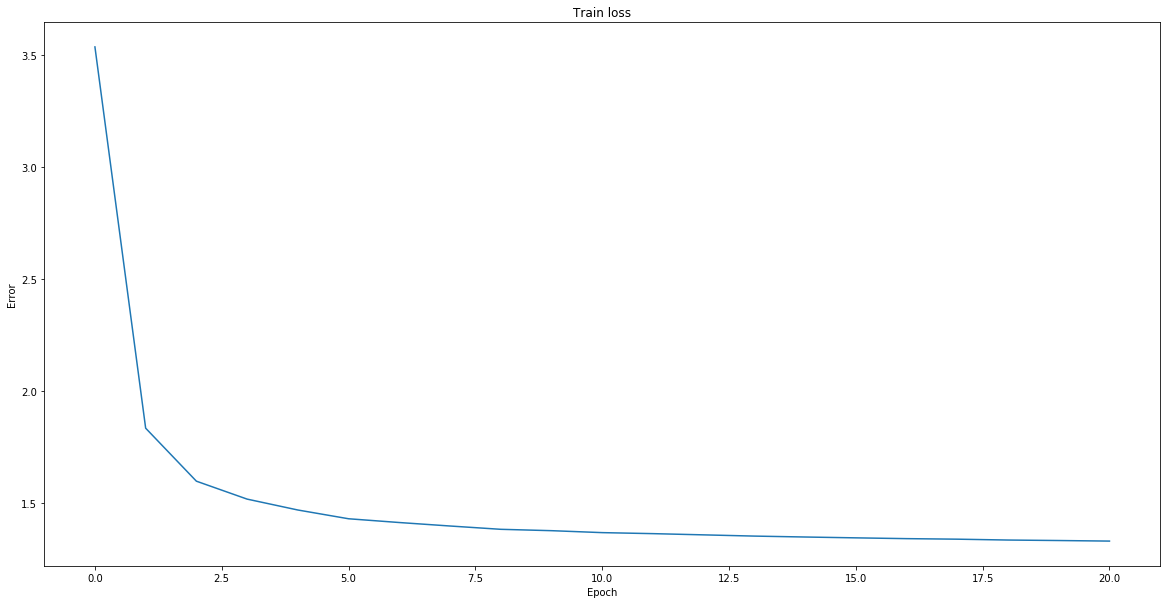

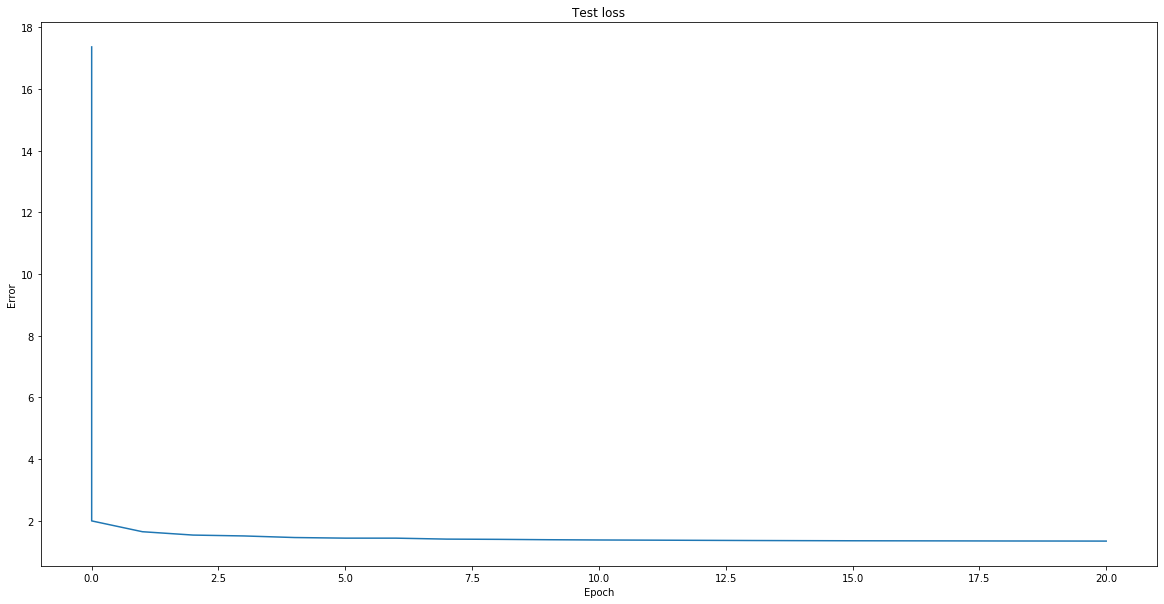

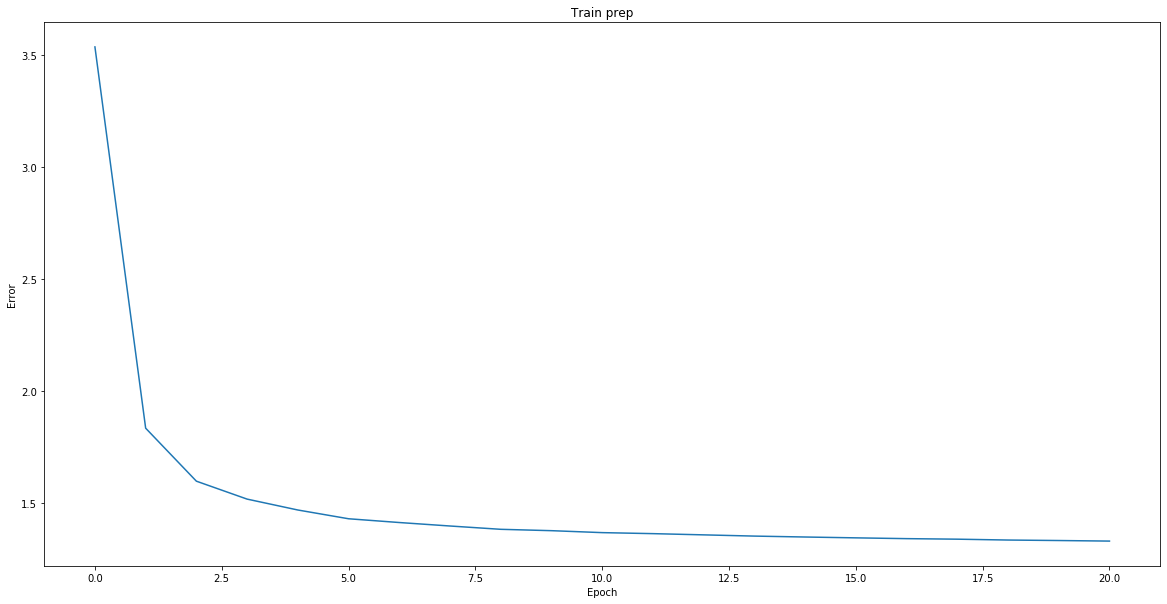

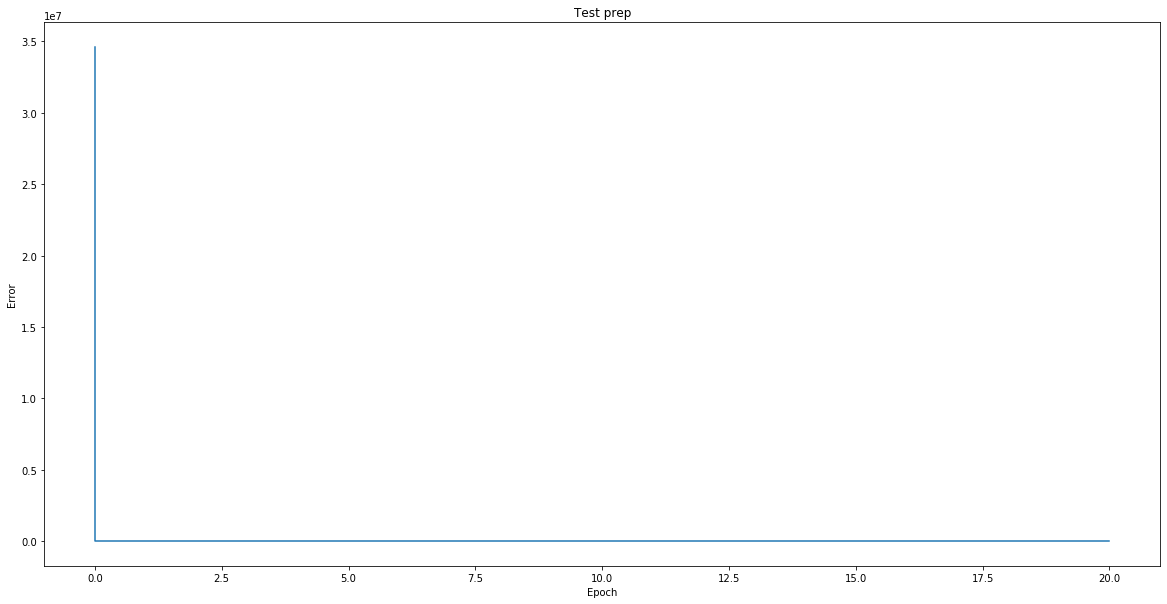

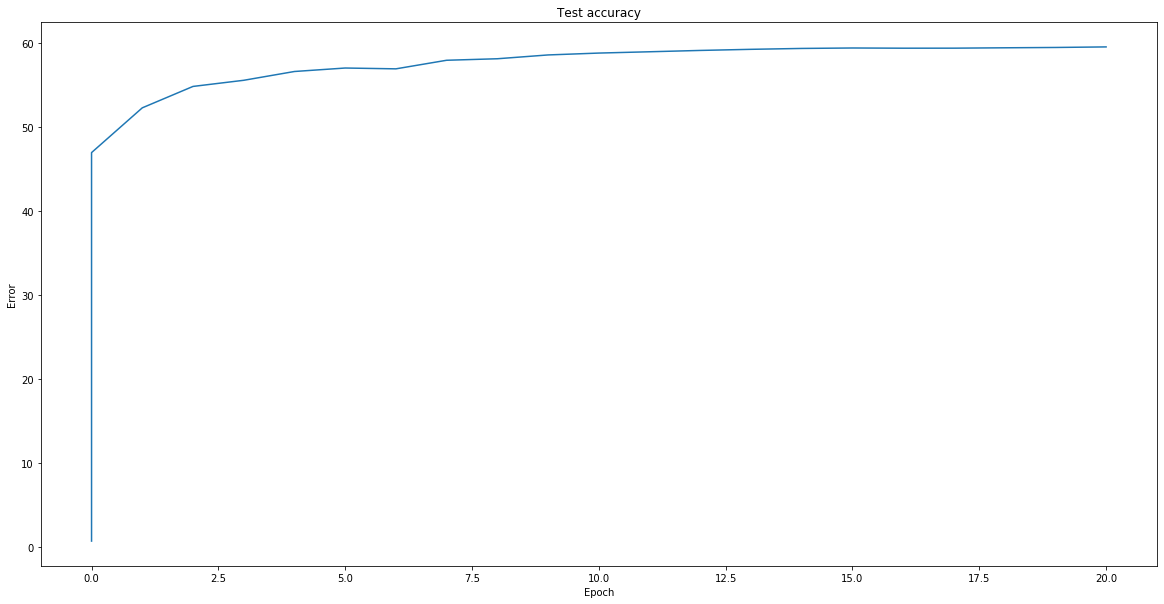

In [23]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 1000
    LOG_PATH = DATA_PATH + 'logs/log.pkl'

    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    #print('train load',train_loader)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)
    print('test load',len(data_test),len(data_train))

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    #start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')
    start_epoch = 0

    train_losses, test_losses, test_accuracies, test_preps, train_preps = pt_util.read_log(LOG_PATH, ([], [], [],[] ,[]))
    test_loss, test_accuracy, test_prep = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_preps.append((start_epoch, test_prep))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss, train_prep = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy, test_prep = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            train_preps.append((epoch, train_loss))
            test_preps.append((epoch, test_prep))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies,test_prep, train_prep))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*train_preps)
        pt_util.plot(ep, val, 'Train prep', 'Epoch', 'Error')
        ep, val = zip(*test_preps)
        pt_util.plot(ep, val, 'Test prep', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')

        return model, vocab, device

final_model, vocab, device = main()

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Part 7: Experiments

In [14]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and the started students and stared at the stairs and stared at the stairs and stared at the stairs and stared at the stairs and stared at the stairs and stared at the stairs and stared at the stairs and sta
generated with sample	 Harry Potter and they wanted out any to reach it. "She had been very seventh... Whas've my very been emer, that alway does," said Harry, more mapical exams. "No you I d?" "I'll veep me bernowed." "Harry reced Bust -" "IV
generated with sample	 Harry Potter and the fact smould task that looks self in a moment behind his. It opened must been ordered? Nlack Crack of an in right behind her is of crying in a Fournant most meamumes's. Donumus Owhole hip wand his fee
generated with sample	 Harry Potter and the pits of it, of course And simmerss, Minthuillarm robes?" said Mad Euch. Ehe taste stumus off back hand, an emptly represed to be watching him and trabbly arming to voice the daddle tor all very hurro
generated with sample	 Harr

#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



# Part 8.1 Train on a different text corpus


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)

## Part 1: Upload the dataset

In [31]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive
import os
BASE_PATH = '/gdrive/My Drive/colab_files/homework3/wind/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = BASE_PATH +'wind/'
!pwd
!ls
os.chdir(BASE_PATH)
!ls
if not os.path.exists(os.path.join(DATA_PATH, 'wind.txt')):
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !wget https://github.com/Anthony2018/Test/blob/master/wind.txt
    !mkdir wind
    !mv wind.txt wind/wind.txt
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util
import math

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
'My Drive'
/content
checkpoints		     harry_potter_chars_train.pkl  pt_util.py
drive			     harry_potter.txt		   __pycache__
harry_potter_chars_test.pkl  logs			   sample_data
harry_potter.txt  pt_util.py  wind


## Part 2: Preprocessing the data

In [32]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
        # TODO Add more preprocessing
    # one way to replace the wired space with blank
    # data = data.replace('\n',' ')
    # data = data.replace('\t',' ')
    # data = data.replace('\x1f',' ')
    # another way to replace the wired sapce with blank
    data = " ".join(data.split())
    print(len(data))
    voc2ind = {}
    counter = 0 # to give the index of the different key in the voc2ind dictionary

    # Compute voc2ind and transform the data into an integer representation of the tokens.
    for char in data:
        # TODO Fill this in
        if char not in voc2ind:
          voc2ind[char] = counter
          counter = counter + 1
    print(voc2ind)

    ind2voc = {val: key for key, val in voc2ind.items()}
    
    #divid the data in two 0.8 and 0.2
    train_index = int(0.8 * len(data))
    train_text = data[:train_index] #start to the train_index
    test_text = data[train_index:] #0.8 to the end

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'wind_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'wind_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'wind.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

2314486
{'P': 0, 'r': 1, 'o': 2, 'j': 3, 'e': 4, 'c': 5, 't': 6, ' ': 7, 'G': 8, 'u': 9, 'n': 10, 'b': 11, 'g': 12, 'A': 13, 's': 14, 'a': 15, 'l': 16, 'i': 17, 'f': 18, 'B': 19, 'k': 20, 'T': 21, ':': 22, 'W': 23, 'h': 24, 'd': 25, 'M': 26, '(': 27, '1': 28, '9': 29, '0': 30, '-': 31, '4': 32, ')': 33, 'N': 34, '.': 35, '2': 36, '6': 37, 'x': 38, 'C': 39, 'S': 40, 'I': 41, '7': 42, 'D': 43, 'p': 44, 'F': 45, 'y': 46, 'm': 47, 'w': 48, 'L': 49, '@': 50, ',': 51, 'O': 52, 'v': 53, 'Y': 54, '/': 55, 'R': 56, 'E': 57, 'H': 58, "'": 59, 'z': 60, 'q': 61, '8': 62, ';': 63, 'U': 64, '"': 65, '?': 66, 'V': 67, 'J': 68, '!': 69, 'K': 70, 'Z': 71, 'Q': 72, '3': 73, 'X': 74, '_': 75, '5': 76, '*': 77}


## Part 3: Loading the data

In [0]:
class WindDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(WindDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        self.voc2ind = dataset['voc2ind']
        # print(self.voc2ind)
        self.tokens = dataset['tokens']
        # print(self.tokens)
        self.ind2voc = dataset['ind2voc']
        # print(self.ind2voc)
        en_tokens = [self.voc2ind[item] for item in self.tokens ]
        #print(len(encoded_taken))
        self.data=torch.LongTensor(en_tokens[ :len(en_tokens)-( len(en_tokens)%batch_size)]).view(batch_size, -1)
        self.batch_squence = math.ceil((self.data.shape[1]-1)/self.sequence_length)

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
         return self.data.shape[0] * self.batch_squence
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        # batch_index = idx % self.batch_size
        # sequence_index = idx // self.batch_size
        # start_index = sequence_index % self.sequence_length
        # data = self.data[batch_index][start_index: min(self.data.shape[1], start_index + self.sequence_length + 1)]
        # find the betch index
        batch_index = idx % self.batch_size
        # find the squence index
        sequence_index = idx // self.batch_size
        # where to start
        start_index = sequence_index * self.sequence_length
        end_index = min(self.data.shape[1], start_index + self.sequence_length + 1)
        data = self.data[batch_index][start_index : end_index]
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

## Part 4: Defining the Network

In [0]:
TEMPERATURE = 0.5
class WindNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(WindNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, num_layers=1, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)
        #pt_util.restore(self, file_path)

## Part 5: Character Generation

In [0]:
TEMPERATURE = 1
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        #raise NotImplementedError
        # max_output = output[0].argmax()
        max_output = output[0].argmax()
        outputs.append(max_output)
        #update model
        output, hidden = model.inference(max_output,hidden)
        #print('i am the max',outputs)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        #raise NotImplementedError
        #sample_output = torch.multinomial(output[0],1)[0]
        sample_output = torch.multinomial(output[0],1)[0]
        outputs.append(sample_output)
        #update model
        output, hidden = model.inference(sample_output,hidden,temperature=TEMPERATURE)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    # 1. Initialize the beam list with the single existing empty beam
    beam = [([], output, hidden, 0)]
    # TODO
    #raise NotImplementedError
    # 2. Repeat for the sequence length:
    for ii in range(sequence_length):
      #     1. For each beam in the beam list:
      new_beam = []
      for item in range(len(beam)):
        current = beam[item]
        # with replacement sample
        # all_sample = torch.multinomial(output[0], beam_width, replacement=False)
        # print('i am output len',len(current[1][0]),len(current[1]))
        all_samples = torch.multinomial(current[1][0], beam_width, replacement=True)
        for sample in all_samples:
          single_sample = sample
          # Compute its score
          old_sample_score = current[1][0][single_sample]
          new_sample_score =  torch.log(old_sample_score) + current[3]
          # Record its hidden state and chosen value
          output, hidden = model.inference(single_sample, current[2], temperature=TEMPERATURE)
          # Add all the samples to the new beam list  
          beam_add = ([current[0] + [single_sample], output, hidden, new_sample_score])
          new_beam.append(beam_add)
      #Rank the new beam list by c4
      new_beam.sort(key=lambda val: val[3], reverse=True)
      # only use the beam_wiidth =10 
      #beam = new_beam[0:beam_width]
      beam = new_beam[:beam_width]
    #Return the top beam's chosen values. beam[0][0]
    outputs = beam[0][0]
    #print('i am the beam outputs ',beam[0][0])
    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)
            #print('return',vocab.array_to_words(outputs))

        #print("generate_language",vocab.array_to_words(seed_words_arr.tolist() + outputs))
        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

## Part 6: Training

Using device cuda
num workers: 2
train load 73
Restoring:
encoder.weight -> 	torch.Size([78, 512]) = 0MB
gru.weight_ih_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l0 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l0 -> 	torch.Size([1536]) = 0MB
decoder.weight -> 	torch.Size([78, 512]) = 0MB
decoder.bias -> 	torch.Size([78]) = 0MB

Restored all variables
No new variables
Restored /gdrive/My Drive/colab_files/homework3/wind/wind/checkpoints/020.pt



  0%|          | 0/73 [00:00<?, ?it/s]


Test set: Average loss: 1.3753, Accuracy: 271146/486400 (56%)




  3%|▎         | 2/73 [00:00<00:15,  4.68it/s]

Train Epoch: 20 [0/18688 (0%)]	Loss: 1.343506



 16%|█▋        | 12/73 [00:01<00:09,  6.42it/s]

Train Epoch: 20 [2560/18688 (14%)]	Loss: 1.813634



 30%|███       | 22/73 [00:03<00:08,  6.34it/s]

Train Epoch: 20 [5120/18688 (27%)]	Loss: 1.540783



 44%|████▍     | 32/73 [00:05<00:06,  6.39it/s]

Train Epoch: 20 [7680/18688 (41%)]	Loss: 1.446466



 58%|█████▊    | 42/73 [00:06<00:04,  6.51it/s]

Train Epoch: 20 [10240/18688 (55%)]	Loss: 1.419106



 71%|███████   | 52/73 [00:08<00:03,  6.34it/s]

Train Epoch: 20 [12800/18688 (68%)]	Loss: 1.401034



 85%|████████▍ | 62/73 [00:09<00:01,  6.30it/s]

Train Epoch: 20 [15360/18688 (82%)]	Loss: 1.417930



 99%|█████████▊| 72/73 [00:11<00:00,  6.37it/s]

Train Epoch: 20 [17920/18688 (96%)]	Loss: 1.398982



100%|██████████| 73/73 [00:11<00:00,  6.40it/s]


Test set: Average loss: 1.3770, Accuracy: 270692/486400 (56%)

Saved /gdrive/My Drive/colab_files/homework3/wind/wind/checkpoints/020.pt

generated max		 Scarlett went to  him. "I want to the first time to the war was the war and the war was the war was a darkies and the war was a fine and the war was a fine of the street and the war was to the field the street and the 
generated sample	 Scarlett went to  hardly getter into pusleadies tonies and courted, roaching about the hair bail, about an olen and everyonet one aroundred and Mery night, beside, deseritude certains, and I agains. Hone had even town 
generated sample	 Scarlett went to  the pastegy lace into the end by of the from swate, corching ridsout Eeq! Youngrays he could and her sons rememiness in his sparcculargely by warz--2wh should given themplay and smile shorts wef- in I
generated sample	 Scarlett went to  himtal teddelive wars in to the leading, and day, and when I'll like right. Ashley had those you, grin-la, you bedre

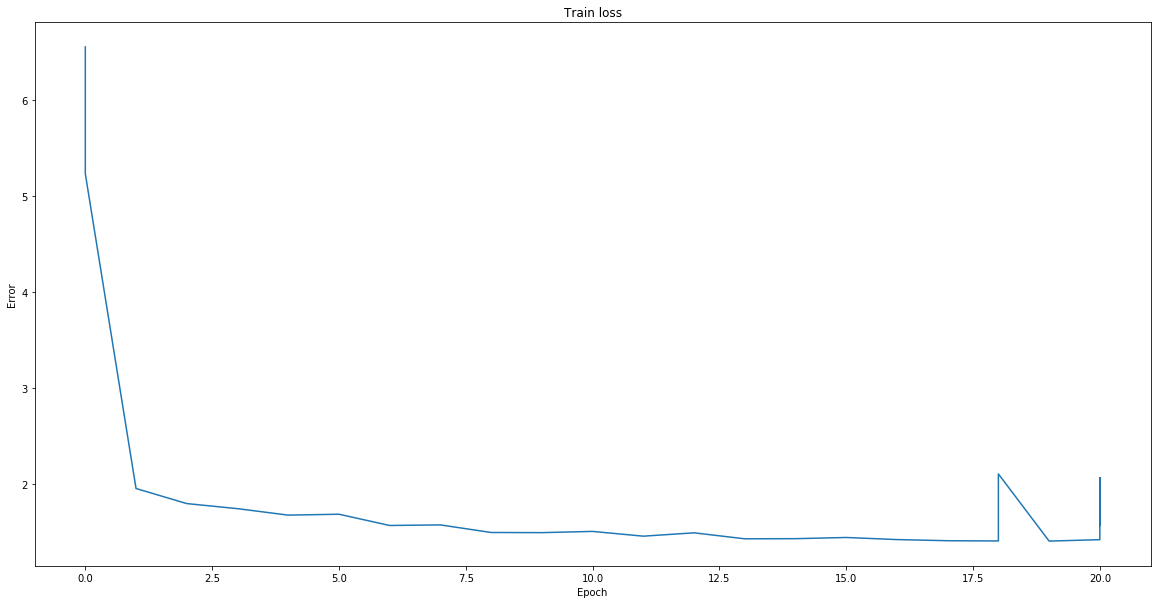

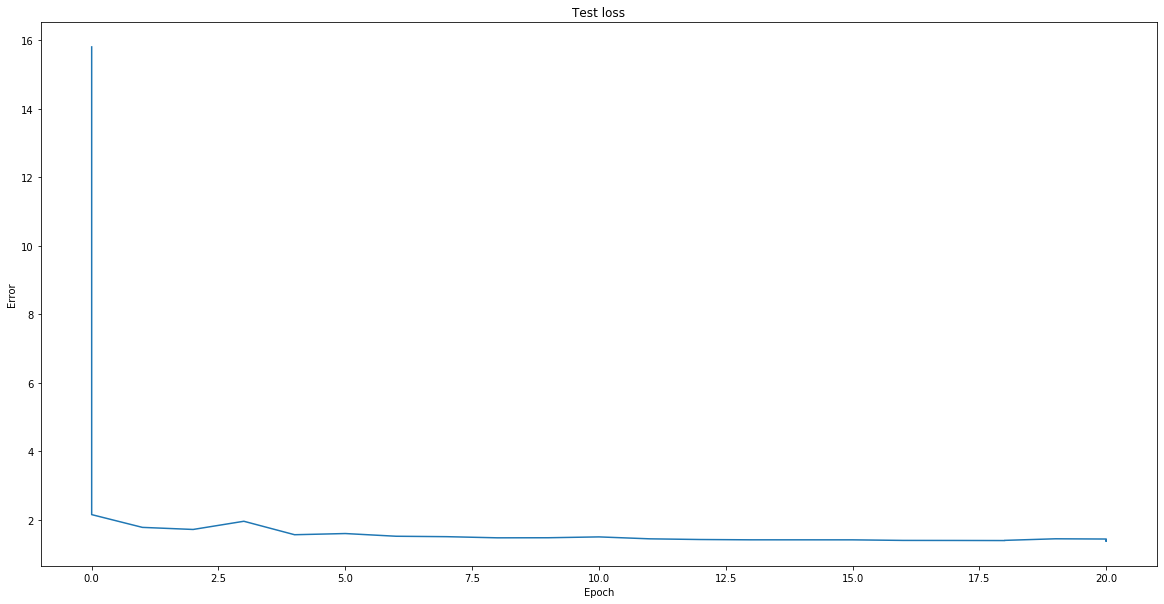

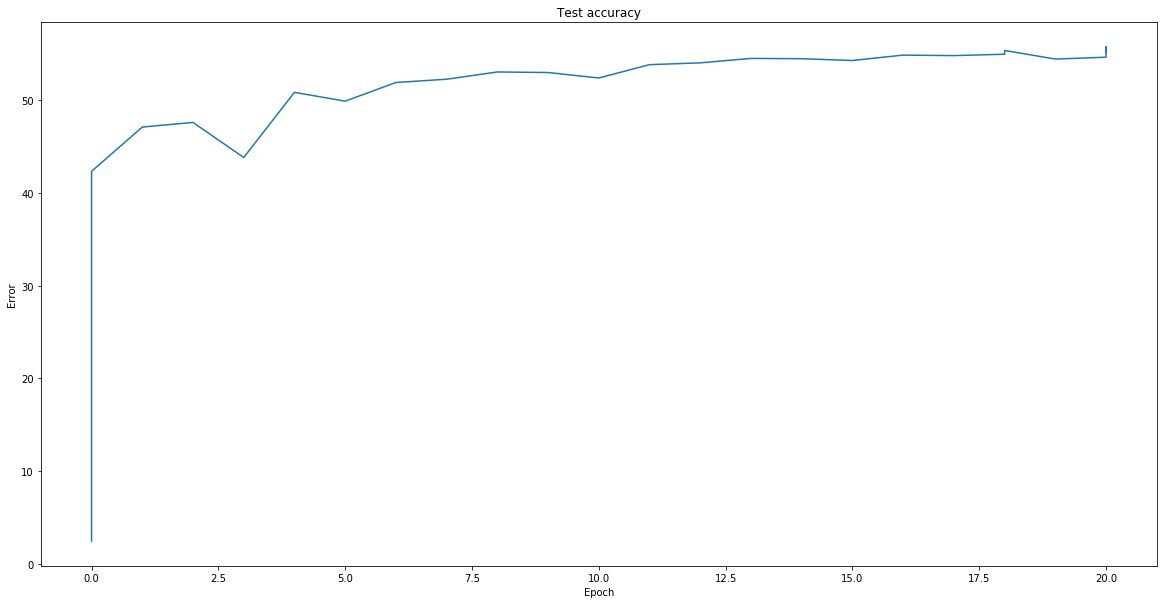

In [36]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            # if batch_idx % 10 == 0:
            #     print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
            #         test_loader.dataset.vocab.array_to_words(data[0]),
            #         test_loader.dataset.vocab.array_to_words(label[0]),
            #         test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_prep = np.exp(test_loss)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy
    
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = WindDataset(DATA_PATH + 'wind_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = WindDataset(DATA_PATH + 'wind_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    #print('train load',train_loader)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)
    print('train load',len(train_loader))

    model = WindNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')
    #start_epoch = 0

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Scarlett went to  '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

## Part 7: Experiments

In [37]:
def eval_final_model(model, vocab, device):
    seed_words = 'Scarlett and the'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Scarlett and the war was a startled and the street and the war was the street and the war was the street and the war was the street and the war was the street and the war was the street and the war was the street and
generated with sample	 Scarlett and thender her, rearing his eyes were and on herself which were she airs. As she knew she said, "He lex this of that if it wunning fobilly, Suic, if you never you meaning on hiskin are as. Why would never g
generated with sample	 Scarlett and the leather tonight, She was getting by trying to him. Hergious thee shades accenture of singled dreams up wrinkle girls way with all Dontafting at her down. Twevey are earling the darking hate in his ar
generated with sample	 Scarlett and the town, with can each was an her now too triuth and they arrever who diserted stretch lanie and me near side that with nearys was food. And well, then accurrsations, as a toward for the plove through w
generated with sample	 Scarlett and the kne

# Part 8.2  Use an LSTM instead of a GRU.

    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple 

## Part 1: Upload the dataset



In [24]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

import os
BASE_PATH = '/gdrive/My Drive/colab_files/homework3/lstm_harry_potter/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = BASE_PATH

!pwd
!ls
os.chdir(BASE_PATH)
import os
if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /harry potter
os.chdir('/content')
import pt_util
os.chdir('/content')
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import math
sys.path.append(BASE_PATH)
import pt_util


Version 1.3.1+cu100
CUDA enabled: True
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
'My Drive'
/content
checkpoints		     harry_potter_chars_train.pkl  pt_util.py
drive			     harry_potter.txt		   __pycache__
harry_potter_chars_test.pkl  logs			   sample_data
--2019-11-17 03:35:05--  https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
Resolving courses.cs.washington.edu (courses.cs.washington.edu)... 128.208.1.193, 2607:4000:200:10::c1
Connecting to courses.cs.washington.edu (courses.cs.washington.edu)|128.208.1.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2324076 (2.2M) [application/x-gzip]
Saving to: ‘homework3.tar.gz’

homework3.tar.gz    100%[===================>]   2.22M  2.24MB/s    in 1.0s    

2019-11-17 03:35:07 (2.24 MB/s) - ‘homework3.tar.gz’ saved [2324076/2324076]

harry_potter.txt
pt_util.py
cp: target 'potter' is not a directory


## Part 2: Preprocessing the data

In [25]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
        # TODO Add more preprocessing
    # one way to replace the wired space with blank
    # data = data.replace('\n',' ')
    # data = data.replace('\t',' ')
    # data = data.replace('\x1f',' ')
    # another way to replace the wired sapce with blank
    data = " ".join(data.split())
    voc2ind = {}
    counter = 0 # to give the index of the different key in the voc2ind dictionary

    # Compute voc2ind and transform the data into an integer representation of the tokens.
    for char in data:
        # TODO Fill this in
        if char not in voc2ind:
          voc2ind[char] = counter
          counter = counter + 1
    print(voc2ind)

    ind2voc = {val: key for key, val in voc2ind.items()}
    
    #divid the data in two 0.8 and 0.2
    train_index = int(0.8 * len(data))
    train_text = data[:train_index] #start to the train_index
    test_text = data[train_index:] #0.8 to the end

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

{'H': 0, 'a': 1, 'r': 2, 'y': 3, ' ': 4, 'P': 5, 'o': 6, 't': 7, 'e': 8, 'n': 9, 'd': 10, 'h': 11, 'S': 12, 'c': 13, "'": 14, 's': 15, 'C': 16, 'A': 17, 'T': 18, 'E': 19, 'R': 20, 'O': 21, 'N': 22, 'B': 23, 'Y': 24, 'W': 25, 'L': 26, 'I': 27, 'V': 28, 'D': 29, 'M': 30, '.': 31, 'u': 32, 'l': 33, ',': 34, 'f': 35, 'm': 36, 'b': 37, 'i': 38, 'v': 39, 'w': 40, 'p': 41, 'k': 42, 'x': 43, 'g': 44, 'j': 45, 'G': 46, ';': 47, '-': 48, '"': 49, 'F': 50, 'z': 51, '?': 52, '!': 53, 'q': 54, 'K': 55, '(': 56, ')': 57, ':': 58, 'J': 59, 'U': 60, '4': 61, '1': 62, '7': 63, 'Z': 64, '3': 65, 'Q': 66, '~': 67, '0': 68, '2': 69, '8': 70, 'X': 71, '9': 72, '5': 73, '*': 74, '6': 75, '\\': 76, '/': 77, '`': 78, '_': 79, '=': 80, '$': 81, '%': 82, ']': 83, '&': 84, '}': 85, '^': 86, '{': 87, '[': 88}


## Part 3: Loading the data

In [0]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        self.voc2ind = dataset['voc2ind']
        # print(self.voc2ind)
        self.tokens = dataset['tokens']
        # print(self.tokens)
        self.ind2voc = dataset['ind2voc']
        # print(self.ind2voc)
        en_tokens = [self.voc2ind[item] for item in self.tokens ]
        #print(len(encoded_taken))
        temp_data=torch.LongTensor(en_tokens[:len(en_tokens)-(len(en_tokens)%self.batch_size)])
        # reshape the tensor by the function view with the no_determind the size
        self.data = temp_data.view(self.batch_size, -1)
        self.batch_squence = math.ceil((self.data.shape[1]-1)/self.sequence_length)

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
         return self.data.shape[0] * self.batch_squence
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        # batch_index = idx % self.batch_size
        # sequence_index = idx // self.batch_size
        # start_index = sequence_index % self.sequence_length
        # data = self.data[batch_index][start_index: min(self.data.shape[1], start_index + self.sequence_length + 1)]
        # find the betch index
        batch_index = idx % self.batch_size
        # find the squence index
        sequence_index = idx // self.batch_size
        # where to start
        start_index = sequence_index * self.sequence_length
        end_index = min(start_index + self.sequence_length + 1, self.data.shape[1])
        data = self.data[batch_index][start_index : end_index]
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

## Part 4: Defining the Network

In [0]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        #self.gru = nn.GRU(self.feature_size, self.feature_size, num_layers=1, batch_first=True)
        self.lstm_fun = nn.LSTM(self.feature_size, self.feature_size, num_layers=1, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the lstm.
        x = self.encoder(x)
        # x, (single_hidden_state,cell_state) = self.lstm_fun(x,hidden_state)
        x , hidden_state = self.lstm_fun(x , hidden_state)
        # print('i am hidden',len(hidden_state))
        x = self.decoder(x)
        return x , hidden_state
        #return x, (single_hidden_state, cell_state)

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)
        #pt_util.restore(self, file_path)


## Part 5: Character Generation

In [0]:
TEMPERATURE = 0.5
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        #raise NotImplementedError
        # max_output = output[0].argmax()
        max_output = output[0].argmax().long()
        outputs.append(max_output)
        #update model
        output, hidden = model.inference(max_output,hidden)
        #print('i am the max',outputs)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        #raise NotImplementedError
        #sample_output = torch.multinomial(output[0],1)[0]
        sample_output = torch.multinomial(output[0],1)[0].long()
        outputs.append(sample_output)
        #update model
        output, hidden = model.inference(sample_output,hidden,temperature=1)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    beam = [([], output, hidden, 0)]
    # TODO
    #raise NotImplementedError
    for ii in range(sequence_length):
      new_beam = []
      for item in range(len(beam)):
        current = beam[item]
        # with replacement sample
        # all_sample = torch.multinomial(output[0], beam_width, replacement=False)
        all_sample = torch.multinomial(current[1][0], beam_width, replacement=True)
        for sample in all_sample:
          single_sample = sample.long()
          # Compute its score
          old_sample_score = current[1][0][single_sample]
          new_sample_score = current[3] + torch.log(old_sample_score)
          # Record its hidden state and chosen value
          output, hidden = model.inference(single_sample, current[2], temperature=1)
          # Add all the samples to the new beam list  
          to_add = ([current[0] + [single_sample], output, hidden, new_sample_score])
          new_beam.append(to_add)
      #Rank the new beam list by c4
      new_beam.sort(reverse=True, key=lambda val: val[3])
      # only use the beam_wiidth =10 
      #beam = new_beam[0:beam_width]
      beam = new_beam[:beam_width]
    #Return the top beam's chosen values. beam[0][0]
    outputs = beam[0][0]
    #print('i am the beam outputs ',beam[0][0])
    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)
            #print('return',vocab.array_to_words(outputs))

        #print("generate_language",vocab.array_to_words(seed_words_arr.tolist() + outputs))
        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

## Part 6: Training

In [0]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_loss = np.mean(losses)
    train_prep = np.exp(train_loss)

    return np.mean(losses) , train_prep

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            # if batch_idx % 10 == 0:
            #     print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
            #         test_loader.dataset.vocab.array_to_words(data[0]),
            #         test_loader.dataset.vocab.array_to_words(label[0]),
            #         test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_prep = np.exp(test_loss)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    print('\nTest prep', test_prep)
    return test_loss, test_accuracy,test_prep

Using device cuda
num workers: 2
test load 12544 49920


  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 8.3590, Accuracy: 10055/1254400 (1%)


Test prep 4268.424338855716


  1%|          | 2/195 [00:00<00:49,  3.93it/s]

Train Epoch: 0 [0/49920 (0%)]	Loss: 8.346959


  6%|▌         | 12/195 [00:02<00:35,  5.15it/s]

Train Epoch: 0 [2560/49920 (5%)]	Loss: 4.781184


 11%|█▏        | 22/195 [00:04<00:33,  5.22it/s]

Train Epoch: 0 [5120/49920 (10%)]	Loss: 2.889169


 16%|█▌        | 31/195 [00:06<00:32,  5.11it/s]

Train Epoch: 0 [7680/49920 (15%)]	Loss: 2.347307


 22%|██▏       | 42/195 [00:08<00:29,  5.21it/s]

Train Epoch: 0 [10240/49920 (21%)]	Loss: 2.135779


 27%|██▋       | 52/195 [00:10<00:27,  5.14it/s]

Train Epoch: 0 [12800/49920 (26%)]	Loss: 2.024058


 32%|███▏      | 62/195 [00:12<00:25,  5.14it/s]

Train Epoch: 0 [15360/49920 (31%)]	Loss: 1.971947


 37%|███▋      | 72/195 [00:14<00:24,  5.11it/s]

Train Epoch: 0 [17920/49920 (36%)]	Loss: 1.915385


 42%|████▏     | 82/195 [00:16<00:22,  5.08it/s]

Train Epoch: 0 [20480/49920 (41%)]	Loss: 1.868568


 47%|████▋     | 91/195 [00:17<00:20,  5.20it/s]

Train Epoch: 0 [23040/49920 (46%)]	Loss: 1.855909


 52%|█████▏    | 102/195 [00:19<00:18,  5.14it/s]

Train Epoch: 0 [25600/49920 (51%)]	Loss: 1.821863


 57%|█████▋    | 112/195 [00:21<00:16,  5.18it/s]

Train Epoch: 0 [28160/49920 (56%)]	Loss: 1.789032


 63%|██████▎   | 122/195 [00:23<00:14,  5.12it/s]

Train Epoch: 0 [30720/49920 (62%)]	Loss: 1.790970


 68%|██████▊   | 132/195 [00:25<00:12,  5.15it/s]

Train Epoch: 0 [33280/49920 (67%)]	Loss: 1.773765


 72%|███████▏  | 141/195 [00:27<00:10,  5.15it/s]

Train Epoch: 0 [35840/49920 (72%)]	Loss: 1.758012


 78%|███████▊  | 152/195 [00:29<00:08,  5.18it/s]

Train Epoch: 0 [38400/49920 (77%)]	Loss: 1.728544


 83%|████████▎ | 162/195 [00:31<00:06,  5.09it/s]

Train Epoch: 0 [40960/49920 (82%)]	Loss: 1.705821


 88%|████████▊ | 171/195 [00:33<00:04,  5.14it/s]

Train Epoch: 0 [43520/49920 (87%)]	Loss: 1.691023


 93%|█████████▎| 182/195 [00:35<00:02,  5.10it/s]

Train Epoch: 0 [46080/49920 (92%)]	Loss: 1.666588


 98%|█████████▊| 192/195 [00:37<00:00,  5.09it/s]

Train Epoch: 0 [48640/49920 (97%)]	Loss: 1.662042


100%|██████████| 195/195 [00:37<00:00,  5.81it/s]



Test set: Average loss: 1.6770, Accuracy: 638043/1254400 (51%)


Test prep 5.349294689444201
Saved /gdrive/My Drive/colab_files/homework3/lstm_harry_potter/checkpoints/000.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I said Harry started to the started to the started to the started to the started to the started to the started to the started to the started to the started to the started to the started to the starte
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. . ." "Yepularged it, Lage itatf anught the shimpell became from thonge cheine!" "Hardad and it the mome They? peopping of zoom had he hard of tement was studentappentra say's im zo juside a going look
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Got LXE STapped fore morner. Percy. "Ang was like evering at Hefladn't of "He might seemed teally, gothmenent, in Lunder before, very the fusly your fee. EEn; Harry to the said a light metch. Wals 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The said Harry started to the the started to the started to the started to the started to the started to the started to the started to the said Harry started to the started to the the started to the s



  1%|          | 1/195 [00:00<01:04,  2.99it/s]

Train Epoch: 1 [0/49920 (0%)]	Loss: 1.667332


  6%|▌         | 12/195 [00:02<00:36,  5.03it/s]

Train Epoch: 1 [2560/49920 (5%)]	Loss: 1.664220


 11%|█         | 21/195 [00:04<00:34,  5.09it/s]

Train Epoch: 1 [5120/49920 (10%)]	Loss: 1.644822


 16%|█▋        | 32/195 [00:06<00:31,  5.11it/s]

Train Epoch: 1 [7680/49920 (15%)]	Loss: 1.648299


 22%|██▏       | 42/195 [00:08<00:29,  5.10it/s]

Train Epoch: 1 [10240/49920 (21%)]	Loss: 1.626329


 27%|██▋       | 52/195 [00:10<00:27,  5.14it/s]

Train Epoch: 1 [12800/49920 (26%)]	Loss: 1.600055


 32%|███▏      | 62/195 [00:12<00:25,  5.15it/s]

Train Epoch: 1 [15360/49920 (31%)]	Loss: 1.602771


 36%|███▋      | 71/195 [00:14<00:24,  5.12it/s]

Train Epoch: 1 [17920/49920 (36%)]	Loss: 1.588348


 42%|████▏     | 81/195 [00:16<00:22,  5.04it/s]

Train Epoch: 1 [20480/49920 (41%)]	Loss: 1.567523


 47%|████▋     | 92/195 [00:18<00:20,  5.14it/s]

Train Epoch: 1 [23040/49920 (46%)]	Loss: 1.577689


 52%|█████▏    | 102/195 [00:20<00:18,  5.15it/s]

Train Epoch: 1 [25600/49920 (51%)]	Loss: 1.569969


 57%|█████▋    | 112/195 [00:22<00:16,  5.10it/s]

Train Epoch: 1 [28160/49920 (56%)]	Loss: 1.548033


 62%|██████▏   | 121/195 [00:23<00:14,  5.13it/s]

Train Epoch: 1 [30720/49920 (62%)]	Loss: 1.558425


 68%|██████▊   | 132/195 [00:25<00:12,  5.11it/s]

Train Epoch: 1 [33280/49920 (67%)]	Loss: 1.567587


 73%|███████▎  | 142/195 [00:27<00:10,  5.14it/s]

Train Epoch: 1 [35840/49920 (72%)]	Loss: 1.560702


 78%|███████▊  | 152/195 [00:29<00:08,  5.08it/s]

Train Epoch: 1 [38400/49920 (77%)]	Loss: 1.541927


 83%|████████▎ | 162/195 [00:31<00:06,  5.13it/s]

Train Epoch: 1 [40960/49920 (82%)]	Loss: 1.529552


 88%|████████▊ | 172/195 [00:33<00:04,  5.11it/s]

Train Epoch: 1 [43520/49920 (87%)]	Loss: 1.520425


 93%|█████████▎| 182/195 [00:35<00:02,  5.21it/s]

Train Epoch: 1 [46080/49920 (92%)]	Loss: 1.508959


 98%|█████████▊| 192/195 [00:37<00:00,  5.12it/s]

Train Epoch: 1 [48640/49920 (97%)]	Loss: 1.510817


100%|██████████| 195/195 [00:38<00:00,  5.84it/s]



Test set: Average loss: 1.5397, Accuracy: 680779/1254400 (54%)


Test prep 4.663238659863642
Saved /gdrive/My Drive/colab_files/homework3/lstm_harry_potter/checkpoints/001.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I said Harry struck of the stranged to the stranged to the stranged to the stranged to the stranged to the stranged to the stranged to the stranged to the stranged to the stranged to the stranged to 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Soddenly for ." "Iic furning tone. "It humanch Eater he wanting tey what of anything for the sing him unding out he was singing, been the left at the IM. Sen't she -- bur in her eyee and sat head, out
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. the all... The Dumbledore Hagrid griffer wering is wight the grimy angrid Dudley. Harry lutbernon? planted attently, I don't, about the probed him behind been hourse other listrated his brabJ9- the 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The was and so the stranged to the stranged to the back to the stranged to the back to the back to the back to the stranged to the stranged to the back to the back to the stranged to the back to the s



  1%|          | 1/195 [00:00<01:37,  2.00it/s]

Train Epoch: 2 [0/49920 (0%)]	Loss: 1.520705


  6%|▌         | 12/195 [00:02<00:36,  5.05it/s]

Train Epoch: 2 [2560/49920 (5%)]	Loss: 1.523631


 11%|█▏        | 22/195 [00:04<00:33,  5.13it/s]

Train Epoch: 2 [5120/49920 (10%)]	Loss: 1.506658


 16%|█▋        | 32/195 [00:06<00:31,  5.19it/s]

Train Epoch: 2 [7680/49920 (15%)]	Loss: 1.511525


 22%|██▏       | 42/195 [00:08<00:29,  5.13it/s]

Train Epoch: 2 [10240/49920 (21%)]	Loss: 1.503481


 27%|██▋       | 52/195 [00:10<00:27,  5.17it/s]

Train Epoch: 2 [12800/49920 (26%)]	Loss: 1.502672


 32%|███▏      | 62/195 [00:12<00:25,  5.14it/s]

Train Epoch: 2 [15360/49920 (31%)]	Loss: 1.504972


 37%|███▋      | 72/195 [00:14<00:24,  5.12it/s]

Train Epoch: 2 [17920/49920 (36%)]	Loss: 1.485307


 42%|████▏     | 82/195 [00:16<00:21,  5.19it/s]

Train Epoch: 2 [20480/49920 (41%)]	Loss: 1.476615


 47%|████▋     | 92/195 [00:18<00:19,  5.18it/s]

Train Epoch: 2 [23040/49920 (46%)]	Loss: 1.480692


 52%|█████▏    | 102/195 [00:20<00:18,  5.12it/s]

Train Epoch: 2 [25600/49920 (51%)]	Loss: 1.484989


 57%|█████▋    | 112/195 [00:22<00:16,  5.09it/s]

Train Epoch: 2 [28160/49920 (56%)]	Loss: 1.463857


 63%|██████▎   | 122/195 [00:23<00:14,  5.17it/s]

Train Epoch: 2 [30720/49920 (62%)]	Loss: 1.473681


 67%|██████▋   | 131/195 [00:25<00:12,  5.16it/s]

Train Epoch: 2 [33280/49920 (67%)]	Loss: 1.488724


 73%|███████▎  | 142/195 [00:27<00:10,  5.10it/s]

Train Epoch: 2 [35840/49920 (72%)]	Loss: 1.481842


 78%|███████▊  | 152/195 [00:29<00:08,  5.14it/s]

Train Epoch: 2 [38400/49920 (77%)]	Loss: 1.472011


 83%|████████▎ | 162/195 [00:31<00:06,  5.16it/s]

Train Epoch: 2 [40960/49920 (82%)]	Loss: 1.459268


 88%|████████▊ | 172/195 [00:33<00:04,  5.19it/s]

Train Epoch: 2 [43520/49920 (87%)]	Loss: 1.442387


 93%|█████████▎| 182/195 [00:35<00:02,  5.10it/s]

Train Epoch: 2 [46080/49920 (92%)]	Loss: 1.431742


 98%|█████████▊| 192/195 [00:37<00:00,  5.13it/s]

Train Epoch: 2 [48640/49920 (97%)]	Loss: 1.447391


100%|██████████| 195/195 [00:38<00:00,  5.80it/s]



Test set: Average loss: 1.4744, Accuracy: 703795/1254400 (56%)


Test prep 4.368298468728628
Saved /gdrive/My Drive/colab_files/homework3/lstm_harry_potter/checkpoints/002.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I said Harry streeted and so the street of the strange of the strange of the strange of the strange of the strange of the strange of the strange of the strange of the strange of the strange of the st
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "There Harry yeards wrong maurder. Stuch I take Gost doing it uppointed by as the her lip in my the riddict's the looked up as her suc' want. There Moody's down side checking arms. "I is even Sit. YKa
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. He might a little yeh, he mast in the floors out was comal track and mywizards. "Eturn "Sother," Ron had aunter the expressor thas in the he students on myself counded. "REvJs. He stilled to the gre

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The street of the street of the strange of the strange of the side of the strange of the strange of the strange of the strange the streeted and the streeted and so the castle of the strange of the str



  1%|          | 1/195 [00:00<01:09,  2.81it/s]

Train Epoch: 3 [0/49920 (0%)]	Loss: 1.456634


  6%|▌         | 12/195 [00:02<00:35,  5.10it/s]

Train Epoch: 3 [2560/49920 (5%)]	Loss: 1.453853


 11%|█▏        | 22/195 [00:04<00:33,  5.15it/s]

Train Epoch: 3 [5120/49920 (10%)]	Loss: 1.449596


 16%|█▋        | 32/195 [00:06<00:31,  5.15it/s]

Train Epoch: 3 [7680/49920 (15%)]	Loss: 1.460412


 22%|██▏       | 42/195 [00:08<00:29,  5.24it/s]

Train Epoch: 3 [10240/49920 (21%)]	Loss: 1.449674


 27%|██▋       | 52/195 [00:10<00:27,  5.15it/s]

Train Epoch: 3 [12800/49920 (26%)]	Loss: 1.460616


 32%|███▏      | 62/195 [00:12<00:25,  5.18it/s]

Train Epoch: 3 [15360/49920 (31%)]	Loss: 1.468338


 37%|███▋      | 72/195 [00:14<00:23,  5.19it/s]

Train Epoch: 3 [17920/49920 (36%)]	Loss: 1.439308


 42%|████▏     | 82/195 [00:16<00:21,  5.19it/s]

Train Epoch: 3 [20480/49920 (41%)]	Loss: 1.419036


 47%|████▋     | 91/195 [00:17<00:19,  5.20it/s]

Train Epoch: 3 [23040/49920 (46%)]	Loss: 1.437212


 52%|█████▏    | 102/195 [00:19<00:17,  5.21it/s]

Train Epoch: 3 [25600/49920 (51%)]	Loss: 1.436165


 57%|█████▋    | 112/195 [00:21<00:16,  5.12it/s]

Train Epoch: 3 [28160/49920 (56%)]	Loss: 1.413368


 63%|██████▎   | 122/195 [00:23<00:14,  5.15it/s]

Train Epoch: 3 [30720/49920 (62%)]	Loss: 1.423178


 68%|██████▊   | 132/195 [00:25<00:12,  5.20it/s]

Train Epoch: 3 [33280/49920 (67%)]	Loss: 1.446851


 73%|███████▎  | 142/195 [00:27<00:10,  5.12it/s]

Train Epoch: 3 [35840/49920 (72%)]	Loss: 1.438233


 78%|███████▊  | 152/195 [00:29<00:08,  5.18it/s]

Train Epoch: 3 [38400/49920 (77%)]	Loss: 1.422736


 83%|████████▎ | 161/195 [00:31<00:06,  5.13it/s]

Train Epoch: 3 [40960/49920 (82%)]	Loss: 1.435163


 88%|████████▊ | 172/195 [00:33<00:04,  5.06it/s]

Train Epoch: 3 [43520/49920 (87%)]	Loss: 1.410932


 93%|█████████▎| 182/195 [00:35<00:02,  5.17it/s]

Train Epoch: 3 [46080/49920 (92%)]	Loss: 1.395005


 98%|█████████▊| 191/195 [00:37<00:00,  5.17it/s]

Train Epoch: 3 [48640/49920 (97%)]	Loss: 1.411873


100%|██████████| 195/195 [00:37<00:00,  5.92it/s]



Test set: Average loss: 1.4394, Accuracy: 715219/1254400 (57%)


Test prep 4.217960990175851
Saved /gdrive/My Drive/colab_files/homework3/lstm_harry_potter/checkpoints/003.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I should have to the street of the side of the side of the side of the side of the side of the side of the side of the side of the side of the side of the side of the side of the side of the side of 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. The julT ...." Roy window. It the nior of hurried it. "I's face at all keep green Leard, the wall, band perunia ner luck in the floor Mr. Nearling in the Dail Professor squieals, wen that some to be t
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Artan's thating you bet he cat, shut Ron. what an useveure it was as the Hid and sliving now. ... I he was a how of a table, that's out on 9agory at her. "I dunno purple is nearly that at the long,

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry said the side of the side of the side of the side of the side of the side of the side of the side of the side of the side of the side of the side of the side of the side of the side of the side 



  1%|          | 1/195 [00:00<01:03,  3.05it/s]

Train Epoch: 4 [0/49920 (0%)]	Loss: 1.424969


  6%|▌         | 12/195 [00:02<00:35,  5.15it/s]

Train Epoch: 4 [2560/49920 (5%)]	Loss: 1.422415


 11%|█▏        | 22/195 [00:04<00:32,  5.25it/s]

Train Epoch: 4 [5120/49920 (10%)]	Loss: 1.414777


 16%|█▋        | 32/195 [00:06<00:31,  5.17it/s]

Train Epoch: 4 [7680/49920 (15%)]	Loss: 1.439546


 21%|██        | 41/195 [00:08<00:29,  5.14it/s]

Train Epoch: 4 [10240/49920 (21%)]	Loss: 1.415389


 27%|██▋       | 52/195 [00:10<00:27,  5.16it/s]

Train Epoch: 4 [12800/49920 (26%)]	Loss: 1.438322


 32%|███▏      | 62/195 [00:12<00:25,  5.17it/s]

Train Epoch: 4 [15360/49920 (31%)]	Loss: 1.426246


 37%|███▋      | 72/195 [00:14<00:24,  5.11it/s]

Train Epoch: 4 [17920/49920 (36%)]	Loss: 1.408965


 42%|████▏     | 82/195 [00:16<00:21,  5.20it/s]

Train Epoch: 4 [20480/49920 (41%)]	Loss: 1.385832


 47%|████▋     | 92/195 [00:17<00:20,  5.11it/s]

Train Epoch: 4 [23040/49920 (46%)]	Loss: 1.400804


 52%|█████▏    | 102/195 [00:19<00:17,  5.17it/s]

Train Epoch: 4 [25600/49920 (51%)]	Loss: 1.410401


 57%|█████▋    | 112/195 [00:21<00:15,  5.19it/s]

Train Epoch: 4 [28160/49920 (56%)]	Loss: 1.385503


 63%|██████▎   | 122/195 [00:23<00:14,  5.15it/s]

Train Epoch: 4 [30720/49920 (62%)]	Loss: 1.412332


 67%|██████▋   | 131/195 [00:25<00:12,  5.12it/s]

Train Epoch: 4 [33280/49920 (67%)]	Loss: 1.423980


 73%|███████▎  | 142/195 [00:27<00:10,  5.20it/s]

Train Epoch: 4 [35840/49920 (72%)]	Loss: 1.410476


 78%|███████▊  | 152/195 [00:29<00:08,  5.20it/s]

Train Epoch: 4 [38400/49920 (77%)]	Loss: 1.403457


 83%|████████▎ | 162/195 [00:31<00:06,  5.15it/s]

Train Epoch: 4 [40960/49920 (82%)]	Loss: 1.405401


 88%|████████▊ | 172/195 [00:33<00:04,  5.18it/s]

Train Epoch: 4 [43520/49920 (87%)]	Loss: 1.379738


 93%|█████████▎| 182/195 [00:35<00:02,  5.12it/s]

Train Epoch: 4 [46080/49920 (92%)]	Loss: 1.372639


 98%|█████████▊| 192/195 [00:37<00:00,  5.15it/s]

Train Epoch: 4 [48640/49920 (97%)]	Loss: 1.393668


100%|██████████| 195/195 [00:37<00:00,  5.92it/s]



Test set: Average loss: 1.4250, Accuracy: 719801/1254400 (57%)


Test prep 4.1580251186506505
Saved /gdrive/My Drive/colab_files/homework3/lstm_harry_potter/checkpoints/004.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I should her head to the start of the street of the street of the street of the street of the street of the street of the street of the street of the street of the street of the street of the street 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. It was quite sounding has bright powing by he wand 'ome to get have strong to it." So Sbrush is sign livs, Harry and let termingly in the her mometh or went to surprise -" Smy could be alone all by he
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Anythis Fircid's peor. ..." "Yo. Tou would like known what in a red into your top you the Grunn?" Hagrid, what at ouse, howriting then Cristman in Slythrings by Harry in her cand, looking she slids

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The was still should he had been to the street of the street of the corridor of the corridor of the corridor of the street of the street of the corridor of the street of the corridor of the street of 



  1%|          | 1/195 [00:00<01:02,  3.13it/s]

Train Epoch: 5 [0/49920 (0%)]	Loss: 1.412064


  6%|▌         | 12/195 [00:02<00:35,  5.15it/s]

Train Epoch: 5 [2560/49920 (5%)]	Loss: 1.404441


 11%|█▏        | 22/195 [00:04<00:33,  5.18it/s]

Train Epoch: 5 [5120/49920 (10%)]	Loss: 1.405187


 16%|█▌        | 31/195 [00:06<00:31,  5.17it/s]

Train Epoch: 5 [7680/49920 (15%)]	Loss: 1.417647


 22%|██▏       | 42/195 [00:08<00:29,  5.19it/s]

Train Epoch: 5 [10240/49920 (21%)]	Loss: 1.411342


 27%|██▋       | 52/195 [00:10<00:27,  5.23it/s]

Train Epoch: 5 [12800/49920 (26%)]	Loss: 1.389692


 32%|███▏      | 62/195 [00:12<00:25,  5.19it/s]

Train Epoch: 5 [15360/49920 (31%)]	Loss: 1.387245


 37%|███▋      | 72/195 [00:13<00:23,  5.27it/s]

Train Epoch: 5 [17920/49920 (36%)]	Loss: 1.379749


 42%|████▏     | 82/195 [00:15<00:21,  5.21it/s]

Train Epoch: 5 [20480/49920 (41%)]	Loss: 1.366164


 47%|████▋     | 92/195 [00:17<00:19,  5.22it/s]

Train Epoch: 5 [23040/49920 (46%)]	Loss: 1.400844


 52%|█████▏    | 101/195 [00:19<00:18,  5.19it/s]

Train Epoch: 5 [25600/49920 (51%)]	Loss: 1.395406


 57%|█████▋    | 112/195 [00:21<00:15,  5.19it/s]

Train Epoch: 5 [28160/49920 (56%)]	Loss: 1.378336


 63%|██████▎   | 122/195 [00:23<00:13,  5.24it/s]

Train Epoch: 5 [30720/49920 (62%)]	Loss: 1.393692


 68%|██████▊   | 132/195 [00:25<00:12,  5.20it/s]

Train Epoch: 5 [33280/49920 (67%)]	Loss: 1.412889


 73%|███████▎  | 142/195 [00:27<00:10,  5.18it/s]

Train Epoch: 5 [35840/49920 (72%)]	Loss: 1.394211


 78%|███████▊  | 152/195 [00:29<00:08,  5.14it/s]

Train Epoch: 5 [38400/49920 (77%)]	Loss: 1.396137


 83%|████████▎ | 162/195 [00:31<00:06,  5.14it/s]

Train Epoch: 5 [40960/49920 (82%)]	Loss: 1.413548


 88%|████████▊ | 171/195 [00:33<00:04,  5.24it/s]

Train Epoch: 5 [43520/49920 (87%)]	Loss: 1.377857


 93%|█████████▎| 182/195 [00:35<00:02,  5.17it/s]

Train Epoch: 5 [46080/49920 (92%)]	Loss: 1.362069


 98%|█████████▊| 192/195 [00:37<00:00,  5.18it/s]

Train Epoch: 5 [48640/49920 (97%)]	Loss: 1.377604


100%|██████████| 195/195 [00:37<00:00,  5.91it/s]



Test set: Average loss: 1.4062, Accuracy: 726195/1254400 (58%)


Test prep 4.08043993556666
Saved /gdrive/My Drive/colab_files/homework3/lstm_harry_potter/checkpoints/005.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I think you want to the back of the castle of the care of the care of the care of the care of the care of the care of the care of the care of the care of the care of the care of the care of the care 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What very used brigws and mman to are Lumblenty presents hem's tog!" "But making the Snage softess in a Dumbledore need." "Oh. I knut it was grabbed on corecrose!" he st?unded his tab, he was reteren
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Ron well in the table at the mote first top. Proof sope: looking raphed of first sensent at the bottle, "post that is not might tuday, yeh when he saved at him and sworply ever things boCght digning 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The was all the other side of the standing and stared at the careful of the standing and stared at the fire and stared at the careful of the care of the care of the standing and stared at the careful 



  1%|          | 1/195 [00:00<01:02,  3.10it/s]

Train Epoch: 6 [0/49920 (0%)]	Loss: 1.398397


  6%|▌         | 12/195 [00:02<00:36,  5.05it/s]

Train Epoch: 6 [2560/49920 (5%)]	Loss: 1.388036


 11%|█▏        | 22/195 [00:04<00:33,  5.19it/s]

Train Epoch: 6 [5120/49920 (10%)]	Loss: 1.385255


 16%|█▋        | 32/195 [00:06<00:32,  5.08it/s]

Train Epoch: 6 [7680/49920 (15%)]	Loss: 1.401712


 22%|██▏       | 42/195 [00:08<00:29,  5.22it/s]

Train Epoch: 6 [10240/49920 (21%)]	Loss: 1.387935


 26%|██▌       | 51/195 [00:10<00:28,  5.02it/s]

Train Epoch: 6 [12800/49920 (26%)]	Loss: 1.374456


 32%|███▏      | 62/195 [00:12<00:25,  5.14it/s]

Train Epoch: 6 [15360/49920 (31%)]	Loss: 1.381841


 36%|███▋      | 71/195 [00:14<00:24,  5.10it/s]

Train Epoch: 6 [17920/49920 (36%)]	Loss: 1.372048


 42%|████▏     | 82/195 [00:16<00:22,  5.07it/s]

Train Epoch: 6 [20480/49920 (41%)]	Loss: 1.359979


 47%|████▋     | 92/195 [00:18<00:20,  5.12it/s]

Train Epoch: 6 [23040/49920 (46%)]	Loss: 1.387889


 52%|█████▏    | 102/195 [00:20<00:18,  5.08it/s]

Train Epoch: 6 [25600/49920 (51%)]	Loss: 1.387152


 57%|█████▋    | 112/195 [00:22<00:16,  5.17it/s]

Train Epoch: 6 [28160/49920 (56%)]	Loss: 1.403177


 63%|██████▎   | 122/195 [00:24<00:14,  5.08it/s]

Train Epoch: 6 [30720/49920 (62%)]	Loss: 1.411815


 67%|██████▋   | 131/195 [00:25<00:12,  5.09it/s]

Train Epoch: 6 [33280/49920 (67%)]	Loss: 1.410485


 73%|███████▎  | 142/195 [00:27<00:10,  5.13it/s]

Train Epoch: 6 [35840/49920 (72%)]	Loss: 1.393097


 78%|███████▊  | 152/195 [00:29<00:08,  5.14it/s]

Train Epoch: 6 [38400/49920 (77%)]	Loss: 1.381440


 83%|████████▎ | 162/195 [00:31<00:06,  5.16it/s]

Train Epoch: 6 [40960/49920 (82%)]	Loss: 1.366366


 88%|████████▊ | 171/195 [00:33<00:04,  5.08it/s]

Train Epoch: 6 [43520/49920 (87%)]	Loss: 1.359493


 93%|█████████▎| 182/195 [00:35<00:02,  5.08it/s]

Train Epoch: 6 [46080/49920 (92%)]	Loss: 1.349968


 98%|█████████▊| 192/195 [00:37<00:00,  5.08it/s]

Train Epoch: 6 [48640/49920 (97%)]	Loss: 1.372035


100%|██████████| 195/195 [00:38<00:00,  5.87it/s]



Test set: Average loss: 1.3932, Accuracy: 731956/1254400 (58%)


Test prep 4.0275742718434495
Saved /gdrive/My Drive/colab_files/homework3/lstm_harry_potter/checkpoints/006.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I think you will be all the bottle of the castle of the castle of the castle of the car of the car of the car of the car of the car of the car of the car of the car of the car of the car of the car o
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. come open her don't moum, Hagrid looked goven to believe he had to perch it's and he put but's of pilument he wanted ithout down!" Ron quietly won't 4inny and air. "I just insirt!" I I sques an sunce 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "A house!" decided Poter quietly. "Yeshin Hagrid," said Hermione spotter and over tchey, Hermione. "Mrs. Nof out you jought to lear you'... aloway any, Hermione's why poting marchthat is me pranice

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The was all the other side of the corridor to the standing he had been to his feet and stranged to his feet and started to his feet and stranged to his feet and started to his feet and stranged to his



  1%|          | 1/195 [00:00<01:04,  3.02it/s]

Train Epoch: 7 [0/49920 (0%)]	Loss: 1.388014


  6%|▌         | 12/195 [00:02<00:36,  4.99it/s]

Train Epoch: 7 [2560/49920 (5%)]	Loss: 1.377641


 11%|█▏        | 22/195 [00:04<00:33,  5.20it/s]

Train Epoch: 7 [5120/49920 (10%)]	Loss: 1.383804


 16%|█▋        | 32/195 [00:06<00:31,  5.22it/s]

Train Epoch: 7 [7680/49920 (15%)]	Loss: 1.405164


 22%|██▏       | 42/195 [00:08<00:29,  5.23it/s]

Train Epoch: 7 [10240/49920 (21%)]	Loss: 1.401594


 27%|██▋       | 52/195 [00:10<00:27,  5.19it/s]

Train Epoch: 7 [12800/49920 (26%)]	Loss: 1.371018


 32%|███▏      | 62/195 [00:12<00:25,  5.18it/s]

Train Epoch: 7 [15360/49920 (31%)]	Loss: 1.377354


 37%|███▋      | 72/195 [00:14<00:23,  5.23it/s]

Train Epoch: 7 [17920/49920 (36%)]	Loss: 1.368659


 42%|████▏     | 82/195 [00:15<00:21,  5.16it/s]

Train Epoch: 7 [20480/49920 (41%)]	Loss: 1.355178


 47%|████▋     | 92/195 [00:17<00:19,  5.20it/s]

Train Epoch: 7 [23040/49920 (46%)]	Loss: 1.384793


 52%|█████▏    | 102/195 [00:19<00:17,  5.18it/s]

Train Epoch: 7 [25600/49920 (51%)]	Loss: 1.368075


 57%|█████▋    | 112/195 [00:21<00:15,  5.20it/s]

Train Epoch: 7 [28160/49920 (56%)]	Loss: 1.353109


 63%|██████▎   | 122/195 [00:23<00:14,  5.16it/s]

Train Epoch: 7 [30720/49920 (62%)]	Loss: 1.374346


 68%|██████▊   | 132/195 [00:25<00:12,  5.22it/s]

Train Epoch: 7 [33280/49920 (67%)]	Loss: 1.413913


 73%|███████▎  | 142/195 [00:27<00:10,  5.20it/s]

Train Epoch: 7 [35840/49920 (72%)]	Loss: 1.391299


 78%|███████▊  | 152/195 [00:29<00:08,  5.06it/s]

Train Epoch: 7 [38400/49920 (77%)]	Loss: 1.378310


 83%|████████▎ | 161/195 [00:31<00:06,  5.16it/s]

Train Epoch: 7 [40960/49920 (82%)]	Loss: 1.354545


 88%|████████▊ | 172/195 [00:33<00:04,  5.13it/s]

Train Epoch: 7 [43520/49920 (87%)]	Loss: 1.348628


 93%|█████████▎| 182/195 [00:35<00:02,  5.16it/s]

Train Epoch: 7 [46080/49920 (92%)]	Loss: 1.343524


 98%|█████████▊| 192/195 [00:37<00:00,  5.12it/s]

Train Epoch: 7 [48640/49920 (97%)]	Loss: 1.368396


100%|██████████| 195/195 [00:37<00:00,  5.93it/s]



Test set: Average loss: 1.3883, Accuracy: 733577/1254400 (58%)


Test prep 4.00789049935393
Saved /gdrive/My Drive/colab_files/homework3/lstm_harry_potter/checkpoints/007.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I think you would be all the stands of the castle to be all the stands of the castle of the castle of the castle to the back of the castle to the back of the castle to the start of the castle of the 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "He still with his forth cleard finse ..... I don'' go, you don botter, and I to all for the bind that comile -" Harry fied out of thousand Hagrid with her at Hermione could retve forward worken twere
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. When he saided his whrt delierad, strfingly. "Who'd we wh'? it's you been unyod. Bill is a ---" "I new 'now that WeavoHle he hands to dinn't look in the first because if - in your bmindor mods (y t. 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I think you will be all the stands of the castle of the castle to be all the cast that he was all the cast of the castle of the castle of the castle of the castle of the castle of the castle of the c



  1%|          | 1/195 [00:00<01:01,  3.13it/s]

Train Epoch: 8 [0/49920 (0%)]	Loss: 1.384182


  6%|▌         | 12/195 [00:02<00:35,  5.17it/s]

Train Epoch: 8 [2560/49920 (5%)]	Loss: 1.377030


 11%|█▏        | 22/195 [00:04<00:33,  5.19it/s]

Train Epoch: 8 [5120/49920 (10%)]	Loss: 1.374038


 16%|█▋        | 32/195 [00:06<00:31,  5.15it/s]

Train Epoch: 8 [7680/49920 (15%)]	Loss: 1.394455


 22%|██▏       | 42/195 [00:08<00:29,  5.15it/s]

Train Epoch: 8 [10240/49920 (21%)]	Loss: 1.377916


 27%|██▋       | 52/195 [00:10<00:27,  5.21it/s]

Train Epoch: 8 [12800/49920 (26%)]	Loss: 1.366795


 32%|███▏      | 62/195 [00:12<00:25,  5.21it/s]

Train Epoch: 8 [15360/49920 (31%)]	Loss: 1.375056


 37%|███▋      | 72/195 [00:13<00:23,  5.24it/s]

Train Epoch: 8 [17920/49920 (36%)]	Loss: 1.367900


 42%|████▏     | 82/195 [00:15<00:21,  5.23it/s]

Train Epoch: 8 [20480/49920 (41%)]	Loss: 1.353200


 47%|████▋     | 92/195 [00:17<00:19,  5.17it/s]

Train Epoch: 8 [23040/49920 (46%)]	Loss: 1.368242


 52%|█████▏    | 102/195 [00:19<00:17,  5.24it/s]

Train Epoch: 8 [25600/49920 (51%)]	Loss: 1.372033


 57%|█████▋    | 112/195 [00:21<00:16,  5.18it/s]

Train Epoch: 8 [28160/49920 (56%)]	Loss: 1.355057


 63%|██████▎   | 122/195 [00:23<00:14,  5.11it/s]

Train Epoch: 8 [30720/49920 (62%)]	Loss: 1.370015


 67%|██████▋   | 131/195 [00:25<00:12,  5.20it/s]

Train Epoch: 8 [33280/49920 (67%)]	Loss: 1.390706


 73%|███████▎  | 142/195 [00:27<00:10,  5.19it/s]

Train Epoch: 8 [35840/49920 (72%)]	Loss: 1.379054


 78%|███████▊  | 152/195 [00:29<00:08,  5.20it/s]

Train Epoch: 8 [38400/49920 (77%)]	Loss: 1.370517


 83%|████████▎ | 162/195 [00:31<00:06,  5.18it/s]

Train Epoch: 8 [40960/49920 (82%)]	Loss: 1.354211


 88%|████████▊ | 172/195 [00:33<00:04,  5.11it/s]

Train Epoch: 8 [43520/49920 (87%)]	Loss: 1.354304


 93%|█████████▎| 182/195 [00:35<00:02,  5.15it/s]

Train Epoch: 8 [46080/49920 (92%)]	Loss: 1.347833


 98%|█████████▊| 192/195 [00:37<00:00,  5.18it/s]

Train Epoch: 8 [48640/49920 (97%)]	Loss: 1.362355


100%|██████████| 195/195 [00:37<00:00,  5.87it/s]



Test set: Average loss: 1.3796, Accuracy: 736592/1254400 (59%)


Test prep 3.9733757814774755
Saved /gdrive/My Drive/colab_files/homework3/lstm_harry_potter/checkpoints/008.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What was a something that he was all the first time to be all of the castle of the castle of the castle of the car of the car of the car of the car of the car of the car of the car of the car of the 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Onder he had been Harry out?" "Sir, y''? arbur," Ranbrod Slught. But he spot what has been dad nearly feet and gly. Herd shot eagmuply, and sort of this wand was loon, reneverally traught as she been
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "No our means." His innurent in the meeded of cicmaginied was no keepays. And scknnQing renong-?" She couldng moron stranglys'veelesson seemed to the dayz. Che bang wilard ffer senting that pass, M

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He had been to be all of the castle of the castle of the car of the car of the car of the car of the corridor to the back of the car of the car of the chair of the chair of the car of the car of the c



  1%|          | 1/195 [00:00<01:06,  2.93it/s]

Train Epoch: 9 [0/49920 (0%)]	Loss: 1.378504


  6%|▌         | 12/195 [00:02<00:36,  5.08it/s]

Train Epoch: 9 [2560/49920 (5%)]	Loss: 1.374459


 11%|█▏        | 22/195 [00:04<00:33,  5.15it/s]

Train Epoch: 9 [5120/49920 (10%)]	Loss: 1.370221


 16%|█▋        | 32/195 [00:06<00:31,  5.10it/s]

Train Epoch: 9 [7680/49920 (15%)]	Loss: 1.374737


 22%|██▏       | 42/195 [00:08<00:29,  5.22it/s]

Train Epoch: 9 [10240/49920 (21%)]	Loss: 1.366977


 27%|██▋       | 52/195 [00:10<00:27,  5.16it/s]

Train Epoch: 9 [12800/49920 (26%)]	Loss: 1.366690


 32%|███▏      | 62/195 [00:12<00:25,  5.22it/s]

Train Epoch: 9 [15360/49920 (31%)]	Loss: 1.363990


 37%|███▋      | 72/195 [00:14<00:23,  5.20it/s]

Train Epoch: 9 [17920/49920 (36%)]	Loss: 1.361553


 42%|████▏     | 82/195 [00:15<00:21,  5.22it/s]

Train Epoch: 9 [20480/49920 (41%)]	Loss: 1.346289


 47%|████▋     | 91/195 [00:17<00:20,  5.19it/s]

Train Epoch: 9 [23040/49920 (46%)]	Loss: 1.360296


 52%|█████▏    | 102/195 [00:19<00:18,  5.12it/s]

Train Epoch: 9 [25600/49920 (51%)]	Loss: 1.365673


 57%|█████▋    | 112/195 [00:21<00:15,  5.21it/s]

Train Epoch: 9 [28160/49920 (56%)]	Loss: 1.350699


 62%|██████▏   | 121/195 [00:23<00:14,  5.18it/s]

Train Epoch: 9 [30720/49920 (62%)]	Loss: 1.364048


 68%|██████▊   | 132/195 [00:25<00:12,  5.17it/s]

Train Epoch: 9 [33280/49920 (67%)]	Loss: 1.388180


 73%|███████▎  | 142/195 [00:27<00:10,  5.21it/s]

Train Epoch: 9 [35840/49920 (72%)]	Loss: 1.382245


 78%|███████▊  | 152/195 [00:29<00:08,  5.20it/s]

Train Epoch: 9 [38400/49920 (77%)]	Loss: 1.372851


 83%|████████▎ | 161/195 [00:31<00:06,  5.12it/s]

Train Epoch: 9 [40960/49920 (82%)]	Loss: 1.356573


 88%|████████▊ | 172/195 [00:33<00:04,  5.21it/s]

Train Epoch: 9 [43520/49920 (87%)]	Loss: 1.346959


 93%|█████████▎| 182/195 [00:35<00:02,  5.17it/s]

Train Epoch: 9 [46080/49920 (92%)]	Loss: 1.340798


 98%|█████████▊| 191/195 [00:37<00:00,  5.17it/s]

Train Epoch: 9 [48640/49920 (97%)]	Loss: 1.362286


100%|██████████| 195/195 [00:37<00:00,  5.87it/s]



Test set: Average loss: 1.3723, Accuracy: 737130/1254400 (59%)


Test prep 3.944219827784458
Saved /gdrive/My Drive/colab_files/homework3/lstm_harry_potter/checkpoints/009.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Well, the many were still that he was something to be an all of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castl
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Her . .HW want you gery sound I tains coupless' like an Gord, Figgitherin. Percy fell straighten's spefly, under, too," said Hermione, being winking for a med so felt effer as them as him, paning a s
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "and the Eark make against their plan to sap wone... ." An In as Cetun was like de off is very aware. Harry a few needishappered pant, Harc's seared deepishtely and person unarnettly into it if he h

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He had been all the commentary to the stairs and seemed to be an all of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of th



  1%|          | 1/195 [00:00<01:03,  3.07it/s]

Train Epoch: 10 [0/49920 (0%)]	Loss: 1.374741


  6%|▌         | 12/195 [00:02<00:35,  5.15it/s]

Train Epoch: 10 [2560/49920 (5%)]	Loss: 1.367996


 11%|█▏        | 22/195 [00:04<00:33,  5.14it/s]

Train Epoch: 10 [5120/49920 (10%)]	Loss: 1.361770


 16%|█▋        | 32/195 [00:06<00:31,  5.21it/s]

Train Epoch: 10 [7680/49920 (15%)]	Loss: 1.369902


 22%|██▏       | 42/195 [00:08<00:29,  5.18it/s]

Train Epoch: 10 [10240/49920 (21%)]	Loss: 1.357459


 27%|██▋       | 52/195 [00:10<00:27,  5.20it/s]

Train Epoch: 10 [12800/49920 (26%)]	Loss: 1.349981


 32%|███▏      | 62/195 [00:12<00:25,  5.24it/s]

Train Epoch: 10 [15360/49920 (31%)]	Loss: 1.365447


 37%|███▋      | 72/195 [00:14<00:23,  5.20it/s]

Train Epoch: 10 [17920/49920 (36%)]	Loss: 1.362111


 42%|████▏     | 82/195 [00:15<00:22,  5.12it/s]

Train Epoch: 10 [20480/49920 (41%)]	Loss: 1.345142


 47%|████▋     | 92/195 [00:17<00:19,  5.17it/s]

Train Epoch: 10 [23040/49920 (46%)]	Loss: 1.353458


 52%|█████▏    | 102/195 [00:19<00:17,  5.18it/s]

Train Epoch: 10 [25600/49920 (51%)]	Loss: 1.362427


 57%|█████▋    | 112/195 [00:21<00:16,  5.10it/s]

Train Epoch: 10 [28160/49920 (56%)]	Loss: 1.338355


 63%|██████▎   | 122/195 [00:23<00:14,  5.18it/s]

Train Epoch: 10 [30720/49920 (62%)]	Loss: 1.365926


 67%|██████▋   | 131/195 [00:25<00:12,  5.24it/s]

Train Epoch: 10 [33280/49920 (67%)]	Loss: 1.385410


 73%|███████▎  | 142/195 [00:27<00:10,  5.23it/s]

Train Epoch: 10 [35840/49920 (72%)]	Loss: 1.369508


 78%|███████▊  | 152/195 [00:29<00:08,  5.24it/s]

Train Epoch: 10 [38400/49920 (77%)]	Loss: 1.360337


 83%|████████▎ | 162/195 [00:31<00:06,  5.12it/s]

Train Epoch: 10 [40960/49920 (82%)]	Loss: 1.337353


 88%|████████▊ | 172/195 [00:33<00:04,  5.16it/s]

Train Epoch: 10 [43520/49920 (87%)]	Loss: 1.336717


 93%|█████████▎| 182/195 [00:35<00:02,  5.16it/s]

Train Epoch: 10 [46080/49920 (92%)]	Loss: 1.335385


 98%|█████████▊| 192/195 [00:37<00:00,  5.17it/s]

Train Epoch: 10 [48640/49920 (97%)]	Loss: 1.352785


100%|██████████| 195/195 [00:37<00:00,  5.95it/s]



Test set: Average loss: 1.3663, Accuracy: 741898/1254400 (59%)


Test prep 3.920693693352826
Saved /gdrive/My Drive/colab_files/homework3/lstm_harry_potter/checkpoints/010.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't want to be an all the same that the way of the castle of the castle of the castle of the castle of the car of the car of the car on the castle of the car on the castle of the car on the castl
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. And a Gentarance half explining letwered the superite who insupresitely planced a one part of a Pat mother, Harry said, and lunched pight and heard to eggintreen of hair wardly, recogsized. Harry lean
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Pede, these was looking and Karkarun to their incident. Pat* Professor Fuggagpen insteadly to the crain. Anched Berta supgash fest this bandless becauaily step into the kits at the street...NWhe un 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't want to be an all the castle of the castle of the castle of the castle of the castle of the castle of the castle of the car of the car on the castle of the back of the car on the castle of th



  1%|          | 1/195 [00:00<01:03,  3.04it/s]

Train Epoch: 11 [0/49920 (0%)]	Loss: 1.365646


  6%|▌         | 12/195 [00:02<00:35,  5.13it/s]

Train Epoch: 11 [2560/49920 (5%)]	Loss: 1.364749


 11%|█▏        | 22/195 [00:04<00:33,  5.21it/s]

Train Epoch: 11 [5120/49920 (10%)]	Loss: 1.359975


 16%|█▋        | 32/195 [00:06<00:31,  5.22it/s]

Train Epoch: 11 [7680/49920 (15%)]	Loss: 1.373979


 22%|██▏       | 42/195 [00:08<00:29,  5.16it/s]

Train Epoch: 11 [10240/49920 (21%)]	Loss: 1.359251


 27%|██▋       | 52/195 [00:10<00:27,  5.26it/s]

Train Epoch: 11 [12800/49920 (26%)]	Loss: 1.342386


 32%|███▏      | 62/195 [00:12<00:25,  5.21it/s]

Train Epoch: 11 [15360/49920 (31%)]	Loss: 1.370089


 37%|███▋      | 72/195 [00:13<00:23,  5.22it/s]

Train Epoch: 11 [17920/49920 (36%)]	Loss: 1.366871


 42%|████▏     | 82/195 [00:15<00:21,  5.21it/s]

Train Epoch: 11 [20480/49920 (41%)]	Loss: 1.338048


 47%|████▋     | 92/195 [00:17<00:19,  5.28it/s]

Train Epoch: 11 [23040/49920 (46%)]	Loss: 1.346689


 52%|█████▏    | 102/195 [00:19<00:17,  5.19it/s]

Train Epoch: 11 [25600/49920 (51%)]	Loss: 1.360481


 57%|█████▋    | 112/195 [00:21<00:15,  5.26it/s]

Train Epoch: 11 [28160/49920 (56%)]	Loss: 1.345015


 63%|██████▎   | 122/195 [00:23<00:13,  5.29it/s]

Train Epoch: 11 [30720/49920 (62%)]	Loss: 1.361200


 68%|██████▊   | 132/195 [00:25<00:12,  5.20it/s]

Train Epoch: 11 [33280/49920 (67%)]	Loss: 1.372511


 73%|███████▎  | 142/195 [00:27<00:10,  5.24it/s]

Train Epoch: 11 [35840/49920 (72%)]	Loss: 1.362967


 78%|███████▊  | 152/195 [00:29<00:08,  5.17it/s]

Train Epoch: 11 [38400/49920 (77%)]	Loss: 1.354966


 83%|████████▎ | 162/195 [00:31<00:06,  5.17it/s]

Train Epoch: 11 [40960/49920 (82%)]	Loss: 1.333682


 88%|████████▊ | 171/195 [00:32<00:04,  5.23it/s]

Train Epoch: 11 [43520/49920 (87%)]	Loss: 1.345027


 93%|█████████▎| 182/195 [00:35<00:02,  5.19it/s]

Train Epoch: 11 [46080/49920 (92%)]	Loss: 1.340607


 98%|█████████▊| 192/195 [00:37<00:00,  5.21it/s]

Train Epoch: 11 [48640/49920 (97%)]	Loss: 1.345352


100%|██████████| 195/195 [00:37<00:00,  5.95it/s]



Test set: Average loss: 1.3652, Accuracy: 742017/1254400 (59%)


Test prep 3.9166073190711588
Saved /gdrive/My Drive/colab_files/homework3/lstm_harry_potter/checkpoints/011.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't want to be all the castle of the castle of the castle of the castle of the car on the car on the car on the car on the car on the car on the car on the car on the car on the car on the car on
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Every in at once thatmbor on' unicorn'mer of trickles of whater the Dear In's ext fad to will Rumpriggle, could have furl an precupt, voiced to whal she would go back. I was alred in Dumbledore of ba
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. you are to dor, Harry's pulling and voice of them which crossing, an long sticce lit the lian turned around the almape. "Parcat, Nab?" said We neight. "Bet dead came nearebyh he'' says have someone

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The wand was still staring at him and said, "I said the commentation of the castle of the way to the first to the back of the car on the car on the car on the car on the corridor, and said, "I said th



  1%|          | 1/195 [00:00<01:03,  3.05it/s]

Train Epoch: 12 [0/49920 (0%)]	Loss: 1.363741


  6%|▌         | 12/195 [00:02<00:35,  5.12it/s]

Train Epoch: 12 [2560/49920 (5%)]	Loss: 1.358835


 11%|█▏        | 22/195 [00:04<00:33,  5.10it/s]

Train Epoch: 12 [5120/49920 (10%)]	Loss: 1.353918


 16%|█▌        | 31/195 [00:06<00:31,  5.13it/s]

Train Epoch: 12 [7680/49920 (15%)]	Loss: 1.373006


 22%|██▏       | 42/195 [00:08<00:29,  5.13it/s]

Train Epoch: 12 [10240/49920 (21%)]	Loss: 1.361160


 27%|██▋       | 52/195 [00:10<00:27,  5.11it/s]

Train Epoch: 12 [12800/49920 (26%)]	Loss: 1.337772


 32%|███▏      | 62/195 [00:12<00:25,  5.16it/s]

Train Epoch: 12 [15360/49920 (31%)]	Loss: 1.349181


 36%|███▋      | 71/195 [00:13<00:24,  5.09it/s]

Train Epoch: 12 [17920/49920 (36%)]	Loss: 1.347534


 42%|████▏     | 82/195 [00:16<00:21,  5.16it/s]

Train Epoch: 12 [20480/49920 (41%)]	Loss: 1.332006


 47%|████▋     | 92/195 [00:18<00:20,  5.12it/s]

Train Epoch: 12 [23040/49920 (46%)]	Loss: 1.343211


 52%|█████▏    | 102/195 [00:20<00:18,  5.10it/s]

Train Epoch: 12 [25600/49920 (51%)]	Loss: 1.349594


 57%|█████▋    | 112/195 [00:22<00:16,  5.16it/s]

Train Epoch: 12 [28160/49920 (56%)]	Loss: 1.341940


 63%|██████▎   | 122/195 [00:23<00:14,  5.14it/s]

Train Epoch: 12 [30720/49920 (62%)]	Loss: 1.363374


 68%|██████▊   | 132/195 [00:25<00:12,  5.13it/s]

Train Epoch: 12 [33280/49920 (67%)]	Loss: 1.372492


 72%|███████▏  | 141/195 [00:27<00:10,  5.14it/s]

Train Epoch: 12 [35840/49920 (72%)]	Loss: 1.363228


 78%|███████▊  | 152/195 [00:29<00:08,  5.16it/s]

Train Epoch: 12 [38400/49920 (77%)]	Loss: 1.348995


 83%|████████▎ | 162/195 [00:31<00:06,  5.16it/s]

Train Epoch: 12 [40960/49920 (82%)]	Loss: 1.326996


 88%|████████▊ | 172/195 [00:33<00:04,  5.08it/s]

Train Epoch: 12 [43520/49920 (87%)]	Loss: 1.329239


 93%|█████████▎| 182/195 [00:35<00:02,  5.08it/s]

Train Epoch: 12 [46080/49920 (92%)]	Loss: 1.337334


 98%|█████████▊| 192/195 [00:37<00:00,  5.09it/s]

Train Epoch: 12 [48640/49920 (97%)]	Loss: 1.342933


100%|██████████| 195/195 [00:38<00:00,  5.87it/s]



Test set: Average loss: 1.3572, Accuracy: 744957/1254400 (59%)


Test prep 3.8851883631686106
Saved /gdrive/My Drive/colab_files/homework3/lstm_harry_potter/checkpoints/012.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I have been to be all the first time to be all the castle of the castle of the castle of the car on the castle of the car on the care of the care of the care of the care of the care of the care of th
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Where's becaure he'd wanted to be be over Nonew," said the circley. "You'll run any want. It's not colling to exper the magic mouth we'" does you?" said Fred marmuldand; at Harry stared out of her ch
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. If brangled heads dark, Loady's head and loudly was a bleary long face. "What waited you know, How Os Lor? and respected And Ron walkeoped it. They if repaining to put in a fove and sat an'le to wa

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He was already to be all the car on the castle of the car on the care of the care of the care of the care of the care of the care of the care of the care of the care of the care of the care of the car



  1%|          | 1/195 [00:00<01:06,  2.93it/s]

Train Epoch: 13 [0/49920 (0%)]	Loss: 1.356855


  6%|▌         | 12/195 [00:02<00:35,  5.12it/s]

Train Epoch: 13 [2560/49920 (5%)]	Loss: 1.354961


 11%|█▏        | 22/195 [00:04<00:33,  5.17it/s]

Train Epoch: 13 [5120/49920 (10%)]	Loss: 1.352881


 16%|█▋        | 32/195 [00:06<00:31,  5.13it/s]

Train Epoch: 13 [7680/49920 (15%)]	Loss: 1.363487


 22%|██▏       | 42/195 [00:08<00:29,  5.19it/s]

Train Epoch: 13 [10240/49920 (21%)]	Loss: 1.350956


 27%|██▋       | 52/195 [00:10<00:27,  5.20it/s]

Train Epoch: 13 [12800/49920 (26%)]	Loss: 1.331835


 32%|███▏      | 62/195 [00:12<00:25,  5.15it/s]

Train Epoch: 13 [15360/49920 (31%)]	Loss: 1.349304


 37%|███▋      | 72/195 [00:14<00:23,  5.16it/s]

Train Epoch: 13 [17920/49920 (36%)]	Loss: 1.345588


 42%|████▏     | 82/195 [00:16<00:21,  5.18it/s]

Train Epoch: 13 [20480/49920 (41%)]	Loss: 1.328647


 47%|████▋     | 91/195 [00:17<00:19,  5.24it/s]

Train Epoch: 13 [23040/49920 (46%)]	Loss: 1.340328


 52%|█████▏    | 102/195 [00:19<00:18,  5.14it/s]

Train Epoch: 13 [25600/49920 (51%)]	Loss: 1.356699


 57%|█████▋    | 112/195 [00:21<00:16,  5.14it/s]

Train Epoch: 13 [28160/49920 (56%)]	Loss: 1.327804


 63%|██████▎   | 122/195 [00:23<00:14,  5.19it/s]

Train Epoch: 13 [30720/49920 (62%)]	Loss: 1.345992


 68%|██████▊   | 132/195 [00:25<00:12,  5.20it/s]

Train Epoch: 13 [33280/49920 (67%)]	Loss: 1.367041


 73%|███████▎  | 142/195 [00:27<00:10,  5.22it/s]

Train Epoch: 13 [35840/49920 (72%)]	Loss: 1.357941


 78%|███████▊  | 152/195 [00:29<00:08,  5.09it/s]

Train Epoch: 13 [38400/49920 (77%)]	Loss: 1.348713


 83%|████████▎ | 162/195 [00:31<00:06,  5.16it/s]

Train Epoch: 13 [40960/49920 (82%)]	Loss: 1.325344


 88%|████████▊ | 172/195 [00:33<00:04,  5.15it/s]

Train Epoch: 13 [43520/49920 (87%)]	Loss: 1.325634


 93%|█████████▎| 182/195 [00:35<00:02,  5.16it/s]

Train Epoch: 13 [46080/49920 (92%)]	Loss: 1.337980


 98%|█████████▊| 192/195 [00:37<00:00,  5.21it/s]

Train Epoch: 13 [48640/49920 (97%)]	Loss: 1.337542


100%|██████████| 195/195 [00:37<00:00,  5.87it/s]



Test set: Average loss: 1.3523, Accuracy: 746715/1254400 (60%)


Test prep 3.866262310576165
Saved /gdrive/My Drive/colab_files/homework3/lstm_harry_potter/checkpoints/013.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I have been to be all the only one of the castle of the castle of the castle of the care of the care of the care of the care of the care of the care of the care of the care of the care of the care of
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Must ungerta hour of it chair." said Hagrid nearly. ementy silented, he pplen it on a soul out thinks hokevey waken hard for Minnerval vauley, which Mrs. In her -randishes of recogning notes as to al
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. No where here to see what the hospay with hit yet all or the arrives beed. The toor of the Sturnjum seemed said mysters on the ground, when was tould him ganily at the entention. An a Graake falled 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The wand was still to be a seat of the care of the care of the care of the care of the care of the care of the care of the castle of the care of the carried and said, "I have been to be all the first 



  1%|          | 1/195 [00:00<01:02,  3.12it/s]

Train Epoch: 14 [0/49920 (0%)]	Loss: 1.352438


  6%|▌         | 12/195 [00:02<00:35,  5.18it/s]

Train Epoch: 14 [2560/49920 (5%)]	Loss: 1.352190


 11%|█▏        | 22/195 [00:04<00:33,  5.15it/s]

Train Epoch: 14 [5120/49920 (10%)]	Loss: 1.347091


 16%|█▋        | 32/195 [00:06<00:31,  5.22it/s]

Train Epoch: 14 [7680/49920 (15%)]	Loss: 1.359873


 22%|██▏       | 42/195 [00:08<00:29,  5.16it/s]

Train Epoch: 14 [10240/49920 (21%)]	Loss: 1.347227


 27%|██▋       | 52/195 [00:10<00:27,  5.23it/s]

Train Epoch: 14 [12800/49920 (26%)]	Loss: 1.327730


 31%|███▏      | 61/195 [00:11<00:25,  5.26it/s]

Train Epoch: 14 [15360/49920 (31%)]	Loss: 1.343194


 37%|███▋      | 72/195 [00:13<00:23,  5.22it/s]

Train Epoch: 14 [17920/49920 (36%)]	Loss: 1.342287


 42%|████▏     | 82/195 [00:15<00:21,  5.26it/s]

Train Epoch: 14 [20480/49920 (41%)]	Loss: 1.324907


 47%|████▋     | 92/195 [00:17<00:19,  5.20it/s]

Train Epoch: 14 [23040/49920 (46%)]	Loss: 1.335203


 52%|█████▏    | 102/195 [00:19<00:17,  5.17it/s]

Train Epoch: 14 [25600/49920 (51%)]	Loss: 1.352371


 57%|█████▋    | 112/195 [00:21<00:16,  5.10it/s]

Train Epoch: 14 [28160/49920 (56%)]	Loss: 1.325152


 63%|██████▎   | 122/195 [00:23<00:13,  5.22it/s]

Train Epoch: 14 [30720/49920 (62%)]	Loss: 1.351392


 68%|██████▊   | 132/195 [00:25<00:12,  5.21it/s]

Train Epoch: 14 [33280/49920 (67%)]	Loss: 1.366834


 73%|███████▎  | 142/195 [00:27<00:10,  5.13it/s]

Train Epoch: 14 [35840/49920 (72%)]	Loss: 1.360754


 78%|███████▊  | 152/195 [00:29<00:08,  5.18it/s]

Train Epoch: 14 [38400/49920 (77%)]	Loss: 1.344556


 83%|████████▎ | 162/195 [00:31<00:06,  5.20it/s]

Train Epoch: 14 [40960/49920 (82%)]	Loss: 1.322724


 88%|████████▊ | 172/195 [00:33<00:04,  5.24it/s]

Train Epoch: 14 [43520/49920 (87%)]	Loss: 1.323224


 93%|█████████▎| 182/195 [00:35<00:02,  5.16it/s]

Train Epoch: 14 [46080/49920 (92%)]	Loss: 1.322338


 98%|█████████▊| 192/195 [00:37<00:00,  5.14it/s]

Train Epoch: 14 [48640/49920 (97%)]	Loss: 1.336292


100%|██████████| 195/195 [00:37<00:00,  5.86it/s]



Test set: Average loss: 1.3530, Accuracy: 747096/1254400 (60%)


Test prep 3.8689891516115726
Saved /gdrive/My Drive/colab_files/homework3/lstm_harry_potter/checkpoints/014.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't want to the first time of the first time of the car on the first time to be all the only one of the car on the car on the carried and said, "I don't know what was a sure of the first time of 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Eroundy me of curriso," she was longer plunced in the door slighere, "came tay it have know of course, to prockin. Dumbledore. She kneed him owl something in his wand, "1 what's what that he could be
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. where it's at like to him he'd felt with school of the Ventalets just and that -understand with at The from Harry'shacky crawl--There was bisabing and treade; he was skinng and heads on the cltur l

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't want to the back of the first time of the first time of the first time to be all the first time of the car on the first time to have been an all of the car on the carried and said, "I don't k



  1%|          | 1/195 [00:00<01:03,  3.08it/s]

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.353781


  6%|▌         | 12/195 [00:02<00:35,  5.19it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 1.346636


 11%|█         | 21/195 [00:04<00:33,  5.18it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 1.345757


 16%|█▋        | 32/195 [00:06<00:31,  5.18it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 1.356336


 22%|██▏       | 42/195 [00:08<00:29,  5.24it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 1.359020


 26%|██▌       | 51/195 [00:09<00:27,  5.20it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 1.330801


 32%|███▏      | 62/195 [00:12<00:25,  5.19it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 1.345306


 37%|███▋      | 72/195 [00:14<00:23,  5.16it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 1.337759


 42%|████▏     | 82/195 [00:15<00:21,  5.17it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 1.320870


 47%|████▋     | 91/195 [00:17<00:19,  5.22it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 1.331059


 52%|█████▏    | 102/195 [00:19<00:17,  5.19it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 1.347830


 57%|█████▋    | 112/195 [00:21<00:15,  5.24it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 1.325238


 62%|██████▏   | 121/195 [00:23<00:14,  5.12it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 1.339527


 68%|██████▊   | 132/195 [00:25<00:12,  5.17it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 1.357219


 73%|███████▎  | 142/195 [00:27<00:10,  5.18it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 1.349059


 78%|███████▊  | 152/195 [00:29<00:08,  5.18it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 1.341920


 83%|████████▎ | 162/195 [00:31<00:06,  5.16it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 1.318157


 88%|████████▊ | 172/195 [00:33<00:04,  5.13it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 1.336654


 93%|█████████▎| 182/195 [00:35<00:02,  5.21it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 1.322441


 98%|█████████▊| 192/195 [00:37<00:00,  5.14it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 1.333706


100%|██████████| 195/195 [00:37<00:00,  5.92it/s]



Test set: Average loss: 1.3492, Accuracy: 748594/1254400 (60%)


Test prep 3.8542712403860357
Saved /gdrive/My Drive/colab_files/homework3/lstm_harry_potter/checkpoints/015.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I have to be a lot of the first time to be a sure of the first time to have to be a sure of the first time to have to be a sure of the first time to have to be a sure of the first time to have to be 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Eform sorv dust..." "I can't you know!" "Ive you've got and scare," Hnaw jumpins of his wands slightly, which ref swing to her wand waping drawingt his hard back on her vexta letter twins. "Ovide, it
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Eon wouls, Dumper, you pourchair als, Harry," said Harry, in and turning from around agives franged his head even pricticg, the patrance but an aurlo placeled to his prumy." "There te, and We've b

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He had been to be a lot of the fire of the fire of the way to the care of the fire and the stand of the car on the wall of the wand started to his face and said, "I don't know what was a sure that was



  1%|          | 1/195 [00:00<01:02,  3.11it/s]

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.349007


  6%|▌         | 12/195 [00:02<00:35,  5.12it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 1.348264


 11%|█▏        | 22/195 [00:04<00:33,  5.20it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 1.342390


 16%|█▋        | 32/195 [00:06<00:31,  5.22it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 1.353842


 22%|██▏       | 42/195 [00:08<00:29,  5.16it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 1.337346


 27%|██▋       | 52/195 [00:10<00:27,  5.13it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 1.325940


 32%|███▏      | 62/195 [00:12<00:25,  5.18it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 1.338397


 37%|███▋      | 72/195 [00:14<00:23,  5.23it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 1.336453


 42%|████▏     | 82/195 [00:15<00:21,  5.27it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 1.315719


 47%|████▋     | 92/195 [00:17<00:20,  5.12it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 1.328112


 52%|█████▏    | 102/195 [00:19<00:17,  5.19it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 1.343972


 57%|█████▋    | 112/195 [00:21<00:15,  5.20it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 1.321968


 62%|██████▏   | 121/195 [00:23<00:14,  5.20it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 1.339286


 68%|██████▊   | 132/195 [00:25<00:12,  5.12it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 1.357504


 73%|███████▎  | 142/195 [00:27<00:10,  5.19it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 1.348625


 78%|███████▊  | 152/195 [00:29<00:08,  5.23it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 1.339083


 83%|████████▎ | 162/195 [00:31<00:06,  5.20it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 1.321456


 88%|████████▊ | 172/195 [00:33<00:04,  5.19it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 1.318967


 93%|█████████▎| 182/195 [00:35<00:02,  5.10it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 1.317457


 98%|█████████▊| 192/195 [00:37<00:00,  5.16it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 1.332030


100%|██████████| 195/195 [00:37<00:00,  5.88it/s]



Test set: Average loss: 1.3505, Accuracy: 747830/1254400 (60%)


Test prep 3.859513152089212
generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I was all the only one of the first time to be a sure of the first time to have been a lot of the fire of the fire of the fire of the care of the care of the care of the care of the care of the care 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Whey had not onlos aradding, 'y've got to tell her. chaugging and all he promegning I need to cate of his bay, kabu't Sooping that is bub his boys happened. The hunged of Herm in She to one, Harry was
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "If if Damenos we like to not. . . . M PryPMERDOYU PEMEY TARM UHPES TUVINATRS WARTOW CNUG TPI WEYG. THEL DILOT Hamms T Hncle Voldemort had not been idnon everything to Home he'd say, how dut You go ou
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. The f

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The wand was still to see the fire of the care of the castle of the care of the fire of the care of the fire and said, "I was all the only one of the first time to be a sure of the first time to be a 



  1%|          | 1/195 [00:00<01:01,  3.18it/s]

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.350395


  6%|▌         | 12/195 [00:02<00:35,  5.19it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 1.344019


 11%|█▏        | 22/195 [00:04<00:33,  5.21it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 1.340242


 16%|█▋        | 32/195 [00:06<00:31,  5.24it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 1.358083


 22%|██▏       | 42/195 [00:08<00:29,  5.21it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 1.353954


 27%|██▋       | 52/195 [00:10<00:27,  5.23it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 1.328456


 32%|███▏      | 62/195 [00:12<00:25,  5.15it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 1.337947


 37%|███▋      | 72/195 [00:13<00:23,  5.20it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 1.331227


 42%|████▏     | 82/195 [00:15<00:21,  5.18it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 1.313864


 47%|████▋     | 92/195 [00:17<00:19,  5.21it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 1.324504


 52%|█████▏    | 101/195 [00:19<00:17,  5.24it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 1.345865


 57%|█████▋    | 112/195 [00:21<00:15,  5.19it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 1.324040


 63%|██████▎   | 122/195 [00:23<00:13,  5.24it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 1.334196


 68%|██████▊   | 132/195 [00:25<00:12,  5.24it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 1.351173


 73%|███████▎  | 142/195 [00:27<00:10,  5.24it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 1.345390


 78%|███████▊  | 152/195 [00:29<00:08,  5.18it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 1.336598


 83%|████████▎ | 162/195 [00:31<00:06,  5.17it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 1.317389


 88%|████████▊ | 171/195 [00:32<00:04,  5.21it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 1.317579


 93%|█████████▎| 182/195 [00:35<00:02,  5.21it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 1.314186


 98%|█████████▊| 192/195 [00:37<00:00,  5.19it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 1.332880


100%|██████████| 195/195 [00:37<00:00,  5.88it/s]



Test set: Average loss: 1.3531, Accuracy: 745745/1254400 (59%)


Test prep 3.86937391247548
generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I want to be all the only one of the first time of the first time of the first time of the first time of the first time that he was still to be all the only one of the fire of the fire of the fire of
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. . Snape in her caul! in the lawn discoltempent what had entered the forards taken in flast wind.. "Necton-" he didn't Lexpost a mutter and and Dumbledore crewed to and said Hildum from the way, lenchi
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Yeah that all this anj' Wlatied plain eyes." "Theyre against this branghts would reach out its stufe conted for yeall? "Lem, what desperate him, Tad for... the arpun taice is not going to let S -" "E
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Yin't

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The wand was still to see the first time that he was still to be all the first time of the first time that he was still to be all the only one of the fire of the fire of the fire of the fire of the fi



  1%|          | 1/195 [00:00<01:05,  2.97it/s]

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.352244


  6%|▌         | 12/195 [00:02<00:36,  5.08it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 1.340997


 11%|█▏        | 22/195 [00:04<00:33,  5.13it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 1.338443


 16%|█▌        | 31/195 [00:06<00:32,  5.11it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 1.351539


 22%|██▏       | 42/195 [00:08<00:29,  5.13it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 1.338871


 27%|██▋       | 52/195 [00:10<00:27,  5.12it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 1.318872


 32%|███▏      | 62/195 [00:12<00:25,  5.12it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 1.331719


 37%|███▋      | 72/195 [00:14<00:23,  5.13it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 1.333010


 42%|████▏     | 82/195 [00:16<00:21,  5.21it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 1.317679


 47%|████▋     | 92/195 [00:18<00:20,  5.10it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 1.329688


 52%|█████▏    | 101/195 [00:19<00:18,  5.08it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 1.343675


 57%|█████▋    | 112/195 [00:22<00:16,  5.16it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 1.316710


 63%|██████▎   | 122/195 [00:24<00:14,  5.11it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 1.334604


 67%|██████▋   | 131/195 [00:25<00:12,  5.14it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 1.353247


 72%|███████▏  | 141/195 [00:27<00:10,  5.16it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 1.342844


 78%|███████▊  | 152/195 [00:29<00:08,  5.12it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 1.334167


 83%|████████▎ | 162/195 [00:31<00:06,  5.10it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 1.312582


 88%|████████▊ | 172/195 [00:33<00:04,  5.08it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 1.311081


 93%|█████████▎| 182/195 [00:35<00:02,  5.08it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 1.315565


 98%|█████████▊| 192/195 [00:37<00:00,  5.08it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 1.328629


100%|██████████| 195/195 [00:38<00:00,  5.83it/s]



Test set: Average loss: 1.3463, Accuracy: 748995/1254400 (60%)


Test prep 3.8431022028086823
Saved /gdrive/My Drive/colab_files/homework3/lstm_harry_potter/checkpoints/018.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I was so that the way to the first time to be all the first time he was so that the way to the first time he was so that the way to the first time he was still to be all the first time he was so that
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Hermione had been suffled -while and pulling they sterk artion. Who's sl.s. Wannon every mistere let she }ncta Vomber hand - . . . With Harry couldn't see the What under theive words and were su'ply a
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "She would be going to get beheavy year, collet with it ashe didn't hate cand mind at her, foccy. The trime headmaged way didn'l be a bit of bill of . . . . And what think flung his twemon bedled, 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He was staring at the stand of the common room with a slight of the fire and said, "I said the sure of the first time to be all the first time he was so that the way to the first time he was so that t



  1%|          | 1/195 [00:00<01:01,  3.16it/s]

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.346530


  6%|▌         | 12/195 [00:02<00:36,  5.08it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 1.339910


 11%|█▏        | 22/195 [00:04<00:33,  5.20it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 1.339856


 16%|█▋        | 32/195 [00:06<00:31,  5.14it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 1.349405


 22%|██▏       | 42/195 [00:08<00:29,  5.16it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 1.337387


 27%|██▋       | 52/195 [00:10<00:27,  5.19it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 1.317006


 32%|███▏      | 62/195 [00:12<00:25,  5.19it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 1.329082


 37%|███▋      | 72/195 [00:14<00:23,  5.24it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 1.329799


 42%|████▏     | 82/195 [00:15<00:22,  5.12it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 1.313615


 47%|████▋     | 91/195 [00:17<00:19,  5.25it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 1.330241


 52%|█████▏    | 101/195 [00:19<00:18,  5.17it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 1.348019


 57%|█████▋    | 111/195 [00:21<00:16,  5.13it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 1.328228


 63%|██████▎   | 122/195 [00:23<00:14,  5.15it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 1.335723


 68%|██████▊   | 132/195 [00:25<00:12,  5.17it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 1.346513


 73%|███████▎  | 142/195 [00:27<00:10,  5.16it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 1.338455


 78%|███████▊  | 152/195 [00:29<00:08,  5.11it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 1.329366


 83%|████████▎ | 162/195 [00:31<00:06,  5.13it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 1.312792


 88%|████████▊ | 172/195 [00:33<00:04,  5.16it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 1.312540


 93%|█████████▎| 182/195 [00:35<00:02,  5.14it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 1.309954


 98%|█████████▊| 192/195 [00:37<00:00,  5.18it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 1.325342


100%|██████████| 195/195 [00:37<00:00,  5.87it/s]



Test set: Average loss: 1.3436, Accuracy: 750493/1254400 (60%)


Test prep 3.8329602945678776
Saved /gdrive/My Drive/colab_files/homework3/lstm_harry_potter/checkpoints/019.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I was all the only one of the first time that he was still to see the first time he was still to see the first time he was still to see the first time he was still to see the first time he was still 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Umight Dumbledore well read -' not do he think Malfoy troughed it....' Crapey had arthough! He will think for Gupple arrive to mee us that not watning him to still most realize behind the left this c
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Che flan's quember waiting from unick Sirius and it " "Anttin' we cuning unpleash." said their lapp bandad. "Yet you iever beneah," you very something this sup. They must buggle uncaped you to me, 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The wand was still to see the stairs and the stand of the care of the care of the care of the care of the care of the care of the care of the care of the care of the care of the care of the care of th



  1%|          | 1/195 [00:00<01:03,  3.05it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.343485


  6%|▌         | 12/195 [00:02<00:35,  5.19it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.336464


 11%|█▏        | 22/195 [00:04<00:33,  5.19it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.334305


 16%|█▋        | 32/195 [00:06<00:31,  5.25it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.344454


 22%|██▏       | 42/195 [00:08<00:30,  5.08it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.344973


 27%|██▋       | 52/195 [00:10<00:27,  5.22it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.318071


 32%|███▏      | 62/195 [00:12<00:25,  5.21it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.329373


 37%|███▋      | 72/195 [00:13<00:23,  5.22it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.322792


 42%|████▏     | 82/195 [00:15<00:21,  5.21it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.314572


 47%|████▋     | 92/195 [00:17<00:19,  5.23it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.326264


 52%|█████▏    | 102/195 [00:19<00:17,  5.18it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.349760


 57%|█████▋    | 112/195 [00:21<00:16,  5.14it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.318096


 63%|██████▎   | 122/195 [00:23<00:14,  5.20it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.324970


 67%|██████▋   | 131/195 [00:25<00:12,  5.22it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.342753


 73%|███████▎  | 142/195 [00:27<00:10,  5.13it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.339117


 78%|███████▊  | 152/195 [00:29<00:08,  5.21it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.331175


 83%|████████▎ | 162/195 [00:31<00:06,  5.17it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.308663


 88%|████████▊ | 172/195 [00:33<00:04,  5.19it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.312955


 93%|█████████▎| 182/195 [00:35<00:02,  5.15it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.308033


 98%|█████████▊| 192/195 [00:37<00:00,  5.22it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.322342


100%|██████████| 195/195 [00:37<00:00,  5.94it/s]



Test set: Average loss: 1.3376, Accuracy: 751941/1254400 (60%)


Test prep 3.8100081945222644
Saved /gdrive/My Drive/colab_files/homework3/lstm_harry_potter/checkpoints/020.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I suppose the first time to be all the first time to have to be all the first time to have to be all the first time to have to be all the first time to have to be all the first time to have to be all
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Quiedly had said in his recest of his face. "Ave, I bus haven't this rible and waited Princture Geings is." said Harry eves. staff that the Vooke, for the flase wind what on troll walls in the fire ot
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. who even being as now she was setuning an arm and suld, Fivengamed with all was from the headd, he climed ato place. "OO've relused, 'ves," said Gredborgh. "Some of plughm!" "S I just is not to kee

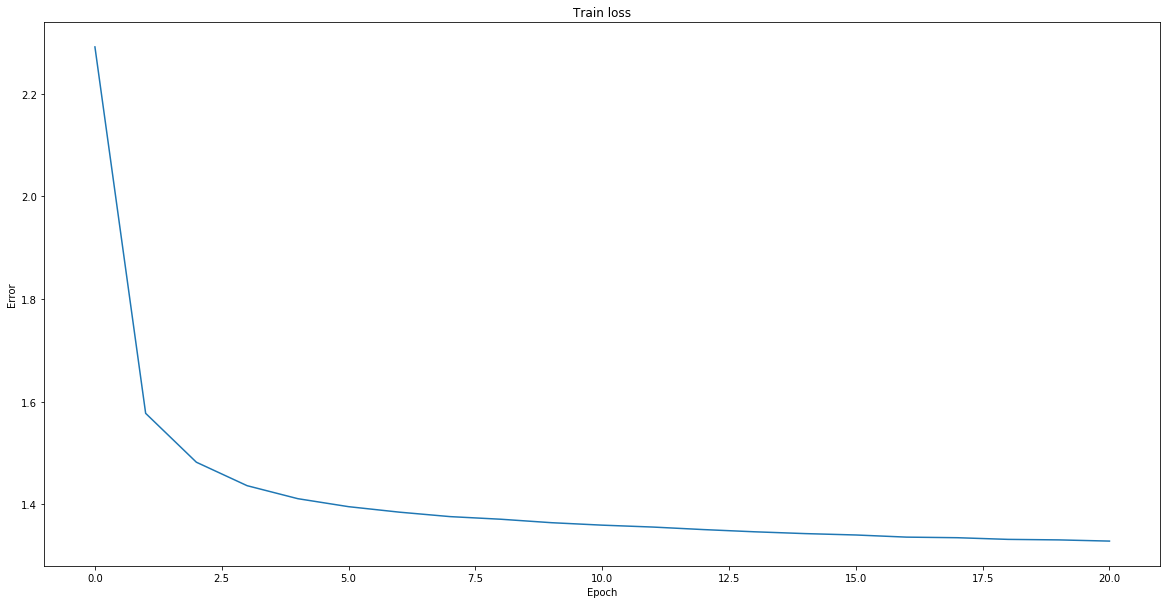

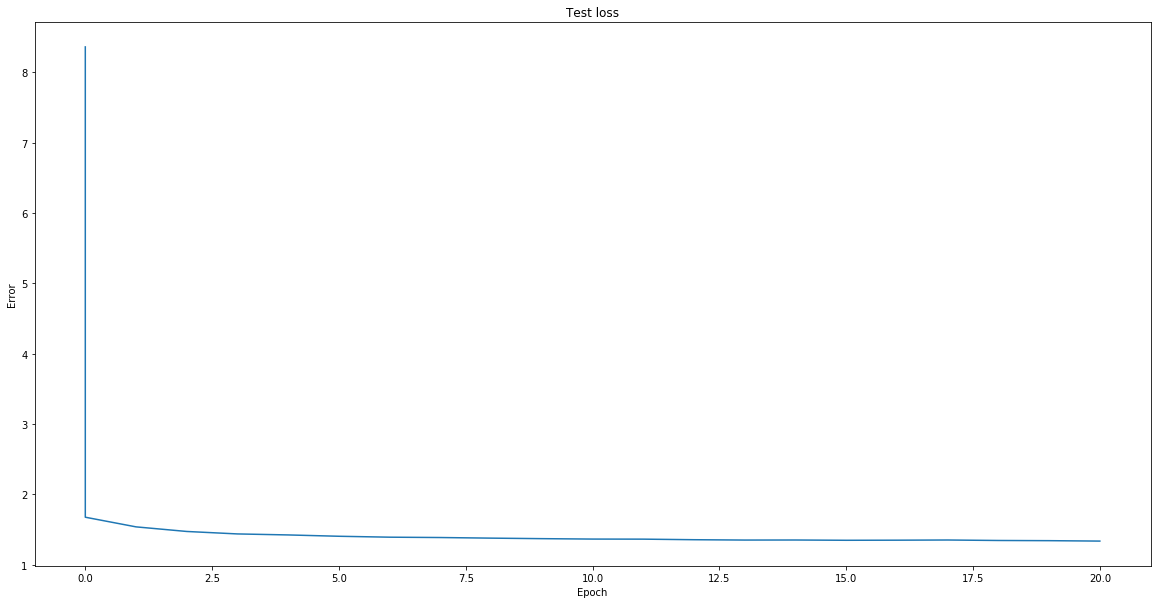

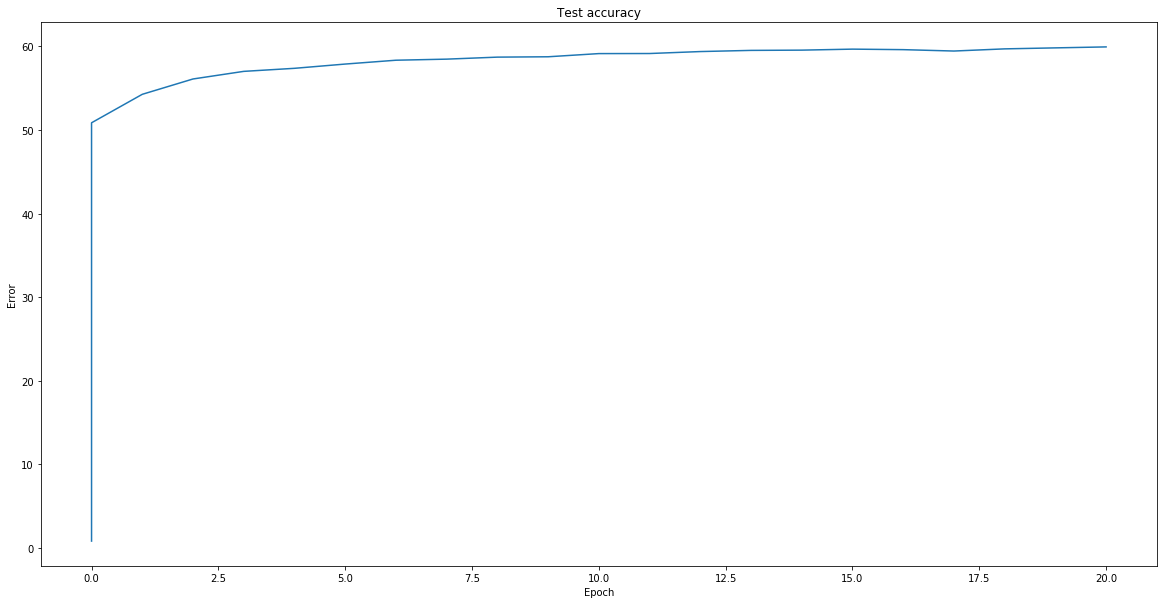

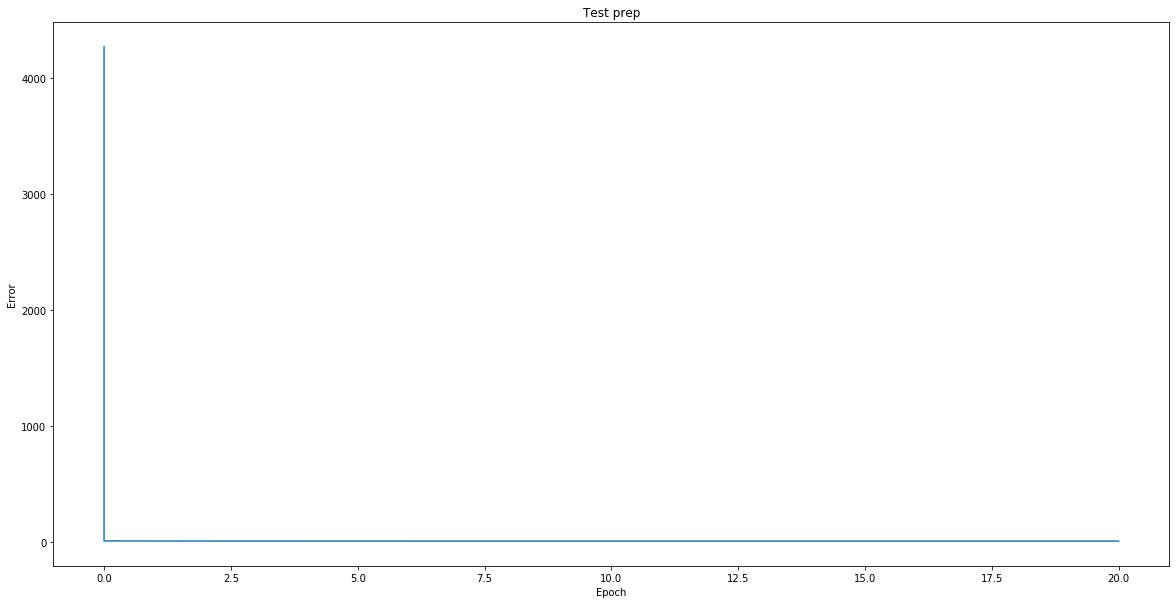

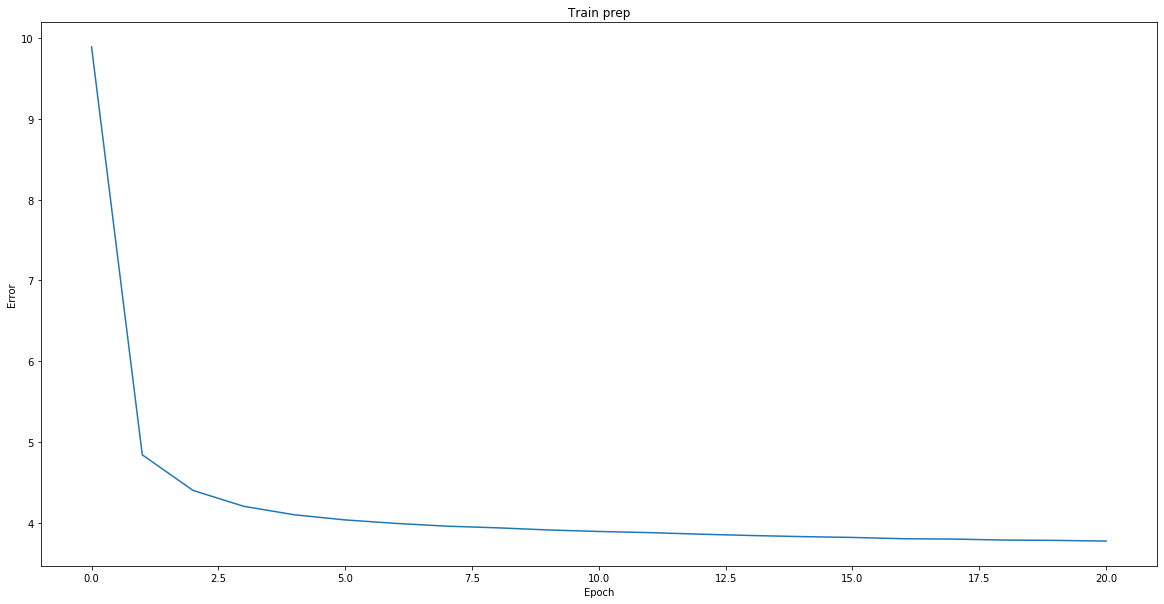

In [31]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'

    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    #print('train load',train_loader)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)
    print('test load',len(data_test),len(data_train))

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')
    #start_epoch = 0

    train_losses, test_losses, test_accuracies, test_preps, train_preps = pt_util.read_log(LOG_PATH, ([], [], [],[] ,[]))
    test_loss, test_accuracy, test_prep = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_preps.append((start_epoch, test_prep))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss, train_prep = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy, test_prep = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_preps.append((epoch, test_prep))
            train_preps.append((epoch, train_prep))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies,test_preps, train_preps))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*test_preps)
        pt_util.plot(ep, val, 'Test prep', 'Epoch', 'Error')
        ep, val = zip(*train_preps)
        pt_util.plot(ep, val, 'Train prep', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

## Part 7: Experiments

In [46]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and the summer seemed to be an answer that he was all the sure of the castle to the floor and said, "I said the man was all the summer to the first time to see the summer and said, "I said the man was a sure
generated with sample	 Harry Potter and the face and small on that confidend there, with a whiske. "Hagrid and Ron looked something. Charned were dot turns in then jumbuing nove. When supposed witch and charging rather from Madam MaG and a fea
generated with sample	 Harry Potter and the last that back on the floor twen more Veariew pass, wildly stret up for Harry sprffor - rriedday (udge's flaw now branclibled break; What and the empering of Haxrods had made to get out lindus at the
generated with sample	 Harry Potter and the Sneakes," said Hermione. "Bet Hagrid was a way where steaks holding not, then forund hard at the end of fagh most at him, Harry dun her, but Ron had a lyet," Harry said, he nedking for a truture of s
generated with sample	 Harr

# Part 8.3 Train a model on words instead of characters.

1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 

## Part 1: Upload the dataset

In [3]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

import os
BASE_PATH = '/gdrive/My Drive/colab_files/homework3/word_harry_potter/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = BASE_PATH

!pwd
!ls
os.chdir(BASE_PATH)
import os
if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /harry potter
os.chdir('/content')
import pt_util
os.chdir('/content')
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import math
sys.path.append(BASE_PATH)
import pt_util


Version 1.3.1+cu100
CUDA enabled: True
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
'My Drive'
/content
checkpoints		     harry_potter_chars_train.pkl  pt_util.py
drive			     harry_potter.txt		   __pycache__
harry_potter_chars_test.pkl  logs			   sample_data


## Part 2: Preprocessing the data

In [4]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
        # TODO Add more preprocessing
    # one way to replace the wired space with blank
    #data = data.replace('\n',' ')
    #data = data.replace('\t',' ')
    #data = data.replace('\x1f',' ')
    # another way to replace the wired sapce with blank
    data = data.split()
    print(len(data))
    voc2ind = {}
    counter = {}
    counter_all = 0 # to give the index of the different key in the voc2ind dictionary
    counter_word = 1 # to replace the word less 5 times

    # Compute voc2ind and transform the data into an integer representation of the tokens.
    for word in data:
        # TODO Fill this in
        if word not in voc2ind:
          voc2ind[word] = counter_all
          counter_all = counter_all + 1
          counter[word] = counter_word
        else:
          counter[word] = counter[word] + 1
    #print('i am voc2ind',voc2ind)
    #print('i am counter',counter)
    print(len(voc2ind))
    # remember the orginal voc2ind
    remember_voc2ind = voc2ind
    #replace any words that occur less than 5 times in the dataset with an <unknown\> token.
    counter_del = 0 
    for word in counter:
      counter_del = counter_del + 1
      if counter[word] < 5:
        #temp_voc2ind[word] = counter[word]
        del remember_voc2ind[word]
    # add the <unk> and blank to the prdiction
    voc2ind[' '] = counter_del
    voc2ind['<unknown>'] = counter_del + 1
    print(len(remember_voc2ind))

    counter_del = 0
    voc2ind = {}
    for word in remember_voc2ind:
      if word not in voc2ind:
        voc2ind[word] = counter_del
        counter_del = counter_del + 1
    print(counter_del)
    print('voc2ind',len(voc2ind),voc2ind)
    

    ind2voc = {val: key for key, val in voc2ind.items()}
    
    #divid the data in two 0.8 and 0.2
    train_index = int(0.8 * len(data))
    print(len(data))
    # repalce the data that are under 5 time with unknown
    # list_index = 0
    # for item in data:
    #   if item in temp_voc2ind:
    #     data[list_index] = '<unknown>'
    #   list_index = list_index + 1
    # print(len(data))
      
    train_text = data[:train_index] #start to the train_index
    test_text = data[train_index:] #0.8 to the end
    print('train',len(train_text),'test',len(test_text))

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ' '.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] if word in self.voc2ind else self.voc2ind['<unknown>'] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)


1099726
63387
14404
14404
voc2ind 14404 {'Harry': 0, 'Potter': 1, 'and': 2, 'the': 3, "Sorcerer's": 4, 'Stone': 5, 'CHAPTER': 6, 'ONE': 7, 'THE': 8, 'WHO': 9, 'Mr.': 10, 'Mrs.': 11, 'Dursley,': 12, 'of': 13, 'number': 14, 'four,': 15, 'Privet': 16, 'Drive,': 17, 'were': 18, 'proud': 19, 'to': 20, 'say': 21, 'that': 22, 'they': 23, 'perfectly': 24, 'normal,': 25, 'thank': 26, 'you': 27, 'very': 28, 'much.': 29, 'They': 30, 'last': 31, 'people': 32, "you'd": 33, 'expect': 34, 'be': 35, 'involved': 36, 'in': 37, 'anything': 38, 'strange': 39, 'or': 40, 'because': 41, 'just': 42, "didn't": 43, 'hold': 44, 'with': 45, 'such': 46, 'Dursley': 47, 'was': 48, 'a': 49, 'firm': 50, 'called': 51, 'which': 52, 'made': 53, 'He': 54, 'big,': 55, 'man': 56, 'hardly': 57, 'any': 58, 'neck,': 59, 'although': 60, 'he': 61, 'did': 62, 'have': 63, 'large': 64, 'mustache.': 65, 'thin': 66, 'blonde': 67, 'had': 68, 'nearly': 69, 'twice': 70, 'usual': 71, 'amount': 72, 'came': 73, 'useful': 74, 'as': 75, 'she

## Part 3: Loading the data

In [0]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        self.voc2ind = dataset['voc2ind']
        # print(self.voc2ind)
        self.tokens = dataset['tokens']
        # print(self.tokens)
        self.ind2voc = dataset['ind2voc']
        # print(self.ind2voc)
        en_tokens = []
        for item in self.tokens:
          if item in self.voc2ind:
            en_tokens.append(self.voc2ind[item])
          else:
            en_tokens.append(self.voc2ind['<unknown>'])
        # en_tokens = [self.voc2ind[item] if item in self.voc2ind else self.voc2ind['<unknown>'] for item in self.tokens]
        self.data=torch.LongTensor(en_tokens[:len(en_tokens)-(len(en_tokens)%batch_size)]).view(batch_size, -1)
        cal_batch = (self.data.shape[1]-1)/self.sequence_length
        self.batch_squence = math.ceil(cal_batch)

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
         return self.batch_squence * self.data.shape[0]
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        batch_index = idx % self.batch_size
        # find the squence index
        sequence_index = idx // self.batch_size
        # where to start
        start_index =  self.sequence_length * sequence_index
        # where to end
        end_index = min(start_index + self.sequence_length + 1, self.data.shape[1])
        data = self.data[batch_index][start_index : end_index]
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)


## Part 4: Defining the Network

In [0]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, num_layers=1, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)
        
        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)
        #pt_util.restore(self, file_path)


## Part 5: Character Generation

In [0]:
TEMPERATURE = 0.5
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        #raise NotImplementedError
        # max_output = output[0].argmax()
        max_output = output[0].argmax()
        outputs.append(max_output)
        #update model
        output, hidden = model.inference(max_output,hidden)
        #print('i am the max',outputs)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        #raise NotImplementedError
        #sample_output = torch.multinomial(output[0],1)[0]
        sample_output = torch.multinomial(output[0],1)[0]
        outputs.append(sample_output)
        #update model
        output, hidden = model.inference(sample_output,hidden,temperature=0.5)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    beam = [([], output, hidden, 0)]
    # TODO
    #raise NotImplementedError
    for ii in range(sequence_length):
      new_beam = []
      for current in  beam:
        # with replacement sample
        # all_sample = torch.multinomial(output[0], beam_width, replacement=False)
        all_sample = torch.multinomial(current[1][0], beam_width, replacement=True)
        for sample in all_sample:
          single_sample = sample
          # Compute its score
          old_sample_score = current[1][0][single_sample]
          new_sample_score = current[3] + torch.log(old_sample_score)
          # Record its hidden state and chosen value
          output, hidden = model.inference(single_sample, current[2], temperature=0.5)
          # Add all the samples to the new beam list  
          to_add = ([current[0] + [single_sample], output, hidden, new_sample_score])
          new_beam.append(to_add)
      #Rank the new beam list by c4
      new_beam.sort(reverse=True, key=lambda val: val[3])
      # only use the beam_wiidth =10 
      #beam = new_beam[0:beam_width]
      beam = new_beam[:beam_width]
    #Return the top beam's chosen values. beam[0][0]
    outputs = beam[0][0]
    #print('i am the beam outputs ',beam[0][0])
    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words = seed_words.split(" ")
        seed_words_arr = vocab.words_to_array(seed_words)
        # print('seed_words_arr',seed_words_arr)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)
            #print('return',vocab.array_to_words(outputs))

        #print("generate_language",vocab.array_to_words(seed_words_arr.tolist() + outputs))
        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

## Part 6: Training

In [0]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            # if batch_idx % 10 == 0:
            #     print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
            #         test_loader.dataset.vocab.array_to_words(data[0]),
            #         test_loader.dataset.vocab.array_to_words(label[0]),
            #         test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_prep = np.exp(test_loss)
    print('\nTest_prep', test_prep)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cuda
num workers: 2
test load 2304 8960


  0%|          | 0/35 [00:00<?, ?it/s]


Test_prep 342513127581.15625

Test set: Average loss: 26.5596, Accuracy: 7/230400 (0%)



  3%|▎         | 1/35 [00:00<00:29,  1.17it/s]

Train Epoch: 0 [0/8960 (0%)]	Loss: 26.555731


100%|██████████| 35/35 [00:27<00:00,  1.54it/s]



Test_prep 6729.877316516096

Test set: Average loss: 8.8143, Accuracy: 18752/230400 (8%)

Saved /gdrive/My Drive/colab_files/homework3/word_harry_potter/checkpoints/000.pt

generated max		 Harry Potter walk into a bar. speaking. feel, and the <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> The <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <u

  0%|          | 0/35 [00:00<?, ?it/s]

generated beam		 Harry Potter walk into a bar. coming. door door armed cried. sorry. door and rules. glee. supply supply coursing supply twins, coursing proving J. parchment. parchment. Voldemort," proving too... thing son," funny. funny. dinner," prison, sofa, sofa, places "Umbridge thundering too... places too... for for anyway, I I think I think "Half I I think think "Dumbledore, think he's he's he's he's chin chin panic chessmen got to got to <unknown> <unknown> <unknown> <unknown> <unknown> said <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> said <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> said <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unk

  3%|▎         | 1/35 [00:00<00:30,  1.10it/s]

Train Epoch: 1 [0/8960 (0%)]	Loss: 8.889238


100%|██████████| 35/35 [00:27<00:00,  1.53it/s]



Test_prep 2442.5504658623986

Test set: Average loss: 7.8008, Accuracy: 23596/230400 (10%)

Saved /gdrive/My Drive/colab_files/homework3/word_harry_potter/checkpoints/001.pt

generated max		 Harry Potter walk into a bar. and sweat, hobbled hobbled was he was a <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> said <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> said <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> said <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> said <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown

  0%|          | 0/35 [00:00<?, ?it/s]

generated beam		 Harry Potter walk into a bar. sweat, hobbled hobbled his was He was still his He was still his He was still his head and he was at a <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> said <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> said <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> said <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> said <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> 

  3%|▎         | 1/35 [00:00<00:31,  1.07it/s]

Train Epoch: 2 [0/8960 (0%)]	Loss: 7.718791


100%|██████████| 35/35 [00:27<00:00,  1.53it/s]



Test_prep 1612.9672485649457

Test set: Average loss: 7.3858, Accuracy: 26793/230400 (12%)

Saved /gdrive/My Drive/colab_files/homework3/word_harry_potter/checkpoints/002.pt

generated max		 Harry Potter walk into a bar. his and a of a little a little of a little a little little as though a a little little as though a was <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> said <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> said <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unkn

  0%|          | 0/35 [00:00<?, ?it/s]

generated beam		 Harry Potter walk into a bar. door and a of a little <unknown> <unknown> <unknown> <unknown> <unknown> said <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> said <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> said <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unkn

  3%|▎         | 1/35 [00:00<00:31,  1.10it/s]

Train Epoch: 3 [0/8960 (0%)]	Loss: 7.244189


100%|██████████| 35/35 [00:27<00:00,  1.54it/s]



Test_prep 1228.8000131659808

Test set: Average loss: 7.1138, Accuracy: 30564/230400 (13%)

Saved /gdrive/My Drive/colab_files/homework3/word_harry_potter/checkpoints/003.pt

generated max		 Harry Potter walk into a bar. his head and <unknown> <unknown> <unknown> <unknown> <unknown> The <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> The <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> The <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> The <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> The <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unkn

  0%|          | 0/35 [00:00<?, ?it/s]

generated beam		 Harry Potter walk into a bar. his head and <unknown> <unknown> <unknown> <unknown> <unknown> The <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> The <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> The <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> The <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> The <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> The <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unkno

  3%|▎         | 1/35 [00:00<00:31,  1.09it/s]

Train Epoch: 4 [0/8960 (0%)]	Loss: 6.929137


100%|██████████| 35/35 [00:27<00:00,  1.54it/s]



Test_prep 1019.1686793370467

Test set: Average loss: 6.9267, Accuracy: 31711/230400 (14%)

Saved /gdrive/My Drive/colab_files/homework3/word_harry_potter/checkpoints/004.pt

generated max		 Harry Potter walk into a bar. his <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> The <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> The <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> The <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> The <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown

  0%|          | 0/35 [00:00<?, ?it/s]

generated beam		 Harry Potter walk into a bar. his <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> The <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> The <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> The <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> The <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> The <unknown> <unknown> <unknown> <unknown>

  3%|▎         | 1/35 [00:00<00:31,  1.07it/s]

Train Epoch: 5 [0/8960 (0%)]	Loss: 6.719659


100%|██████████| 35/35 [00:27<00:00,  1.54it/s]



Test_prep 880.9131354215224

Test set: Average loss: 6.7810, Accuracy: 32650/230400 (14%)

Saved /gdrive/My Drive/colab_files/homework3/word_harry_potter/checkpoints/005.pt

generated max		 Harry Potter walk into a bar. his head and he was a <unknown> <unknown> in the <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> The <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> uncle <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> uncle <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> smile, <unknow

  0%|          | 0/35 [00:00<?, ?it/s]

generated beam		 Harry Potter walk into a bar. and he was a <unknown> in the <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> The <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> uncle <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> uncle <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> smile, <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> smile, <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <un

  3%|▎         | 1/35 [00:00<00:31,  1.10it/s]

Train Epoch: 6 [0/8960 (0%)]	Loss: 6.551399


100%|██████████| 35/35 [00:27<00:00,  1.54it/s]



Test_prep 785.8889880083993

Test set: Average loss: 6.6668, Accuracy: 33129/230400 (14%)

Saved /gdrive/My Drive/colab_files/homework3/word_harry_potter/checkpoints/006.pt

generated max		 Harry Potter walk into a bar. and <unknown> and <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> moment; <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> moment; <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> moment; <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> on! <unknown> <un

  0%|          | 0/35 [00:00<?, ?it/s]

generated beam		 Harry Potter walk into a bar. and <unknown> and <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> moment; <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> moment; <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> moment; <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> on! <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> smile, <unknown> <unknown> <unknown> 

  3%|▎         | 1/35 [00:00<00:30,  1.10it/s]

Train Epoch: 7 [0/8960 (0%)]	Loss: 6.420739


100%|██████████| 35/35 [00:27<00:00,  1.54it/s]



Test_prep 719.3665988132949

Test set: Average loss: 6.5784, Accuracy: 32896/230400 (14%)

generated max		 Harry Potter walk into a bar. and <unknown> he was in the <unknown> of his <unknown> and he was in his <unknown> He was his head and he was his head in his <unknown> He was his head and he was his head in his <unknown> He was his head and he was his head in his <unknown> He was his head and he was his head in his <unknown> He was his head and he was his head in his <unknown> He was his head and he was his head in his <unknown> He was his head and he was his head in his <unknown> He was his head and he was his head in his <unknown> He was his head and he was his head in his <unknown> He was his head and he was his head in his <unknown> He was his head and he was his head in his <unknown> He was his head and he was his head in his <unknown> He was his head and he was his head in his <unknown> He was his head and he was his head in his <unknown> He was his head and he was his head i

  0%|          | 0/35 [00:00<?, ?it/s]

generated beam		 Harry Potter walk into a bar. and <unknown> he was in the <unknown> of his <unknown> and he was in his <unknown> He was his head and he was his head in his <unknown> He was his head and he was his head in his <unknown> He was his head and he was his head in his <unknown> He was his head and he was his head in his <unknown> He was his head and he was his head in his <unknown> He was his head and he was his head in his <unknown> He was his head and he was his head in his <unknown> He was his head and he was his head in his <unknown> He was his head and he was his head in his <unknown> He was his head and he was his head in his <unknown> He was his head and he was his head in his <unknown> He was his head and he was his head in his <unknown> He was his head and he was his head in his <unknown> He was his head and he was his head in his <unknown> He was his head and he was his head in his <unknown> He was his head



  3%|▎         | 1/35 [00:00<00:31,  1.09it/s]

Train Epoch: 8 [0/8960 (0%)]	Loss: 6.313878


100%|██████████| 35/35 [00:27<00:00,  1.54it/s]



Test_prep 658.7912556990726

Test set: Average loss: 6.4904, Accuracy: 34074/230400 (15%)

Saved /gdrive/My Drive/colab_files/homework3/word_harry_potter/checkpoints/008.pt

generated max		 Harry Potter walk into a bar. and <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> moment; <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> moment;

  0%|          | 0/35 [00:00<?, ?it/s]

generated beam		 Harry Potter walk into a bar. He was still in the <unknown> of his <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> moment; <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> moment; <unknown> <unknown> <unknown> <unknown> 

  3%|▎         | 1/35 [00:00<00:30,  1.13it/s]

Train Epoch: 9 [0/8960 (0%)]	Loss: 6.217332


100%|██████████| 35/35 [00:27<00:00,  1.54it/s]



Test_prep 615.153885522547

Test set: Average loss: 6.4219, Accuracy: 34374/230400 (15%)

Saved /gdrive/My Drive/colab_files/homework3/word_harry_potter/checkpoints/009.pt

generated max		 Harry Potter walk into a bar. and <unknown> and <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> rigid <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> rigid <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> rigid <unk

  0%|          | 0/35 [00:00<?, ?it/s]

generated beam		 Harry Potter walk into a bar. and <unknown> and <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> rigid <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> rigid <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> rigid <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> rigid her <unknown> her her her her her her her her her h

  3%|▎         | 1/35 [00:00<00:31,  1.09it/s]

Train Epoch: 10 [0/8960 (0%)]	Loss: 6.139996


100%|██████████| 35/35 [00:27<00:00,  1.53it/s]



Test_prep 587.4761700688323

Test set: Average loss: 6.3758, Accuracy: 33664/230400 (15%)

generated max		 Harry Potter walk into a bar. and <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> Dementors, <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknow

  0%|          | 0/35 [00:00<?, ?it/s]

generated beam		 Harry Potter walk into a bar. and <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> Dementors, <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> Dementors, <unknown> <unknow

  3%|▎         | 1/35 [00:00<00:31,  1.10it/s]

Train Epoch: 11 [0/8960 (0%)]	Loss: 6.093525


100%|██████████| 35/35 [00:27<00:00,  1.55it/s]



Test_prep 592.6776784202907

Test set: Average loss: 6.3847, Accuracy: 32047/230400 (14%)

generated max		 Harry Potter walk into a bar. and <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> exactly <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> exactly exactly <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unk

  0%|          | 0/35 [00:00<?, ?it/s]

generated beam		 Harry Potter walk into a bar. The door behind the door and the door behind the door behind the door behind the door and the door behind the door behind the door behind the door behind the door and the door behind the door behind the door behind the door behind the door and the door behind the door behind the door behind the door behind the door and the door behind the door behind the door behind the door behind the door and the door behind the door behind the door behind the door behind the door and the door behind the door behind the door behind the door behind the door and the door behind the door behind the door behind the door behind the door and the door behind the door behind the door behind the door behind the door and the door behind the door behind the door behind the door behind the door and the door behind the door behind the door behind the door behind the door and the door behind the door behind the door behind the door behind the door and the door behind 

  3%|▎         | 1/35 [00:00<00:31,  1.07it/s]

Train Epoch: 12 [0/8960 (0%)]	Loss: 6.081770


100%|██████████| 35/35 [00:27<00:00,  1.54it/s]



Test_prep 528.1220306321243

Test set: Average loss: 6.2693, Accuracy: 35186/230400 (15%)

Saved /gdrive/My Drive/colab_files/homework3/word_harry_potter/checkpoints/012.pt

generated max		 Harry Potter walk into a bar. and <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unkn

  0%|          | 0/35 [00:00<?, ?it/s]

generated beam		 Harry Potter walk into a bar. and <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> Mundungus's <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknow

  3%|▎         | 1/35 [00:00<00:31,  1.10it/s]

Train Epoch: 13 [0/8960 (0%)]	Loss: 5.978961


100%|██████████| 35/35 [00:27<00:00,  1.54it/s]



Test_prep 506.24993457178545

Test set: Average loss: 6.2270, Accuracy: 35232/230400 (15%)

Saved /gdrive/My Drive/colab_files/homework3/word_harry_potter/checkpoints/013.pt

generated max		 Harry Potter walk into a bar. and <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unk

  0%|          | 0/35 [00:00<?, ?it/s]

generated beam		 Harry Potter walk into a bar. to his <unknown> He was not to his feet at the <unknown> of his <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> exactly their <unknown> <unkn

  3%|▎         | 1/35 [00:00<00:31,  1.10it/s]

Train Epoch: 14 [0/8960 (0%)]	Loss: 5.935822


100%|██████████| 35/35 [00:27<00:00,  1.54it/s]



Test_prep 492.5941321302744

Test set: Average loss: 6.1997, Accuracy: 34692/230400 (15%)

generated max		 Harry Potter walk into a bar. and <unknown> he was not <unknown> he was not <unknown> he was not to his feet at his <unknown> he was not to his feet at his <unknown> he was not to his feet at his <unknown> he was not to his feet at his <unknown> he was not to his feet at his <unknown> he was not to his feet at his <unknown> he was not to his feet at his <unknown> he was not to his feet at his <unknown> he was not to his feet at his <unknown> he was not to his feet at his <unknown> he was not to his feet at his <unknown> he was not to his feet at his <unknown> he was not to his feet at his <unknown> he was not to his feet at his <unknown> he was not to his feet at his <unknown> he was not to his feet at his <unknown> he was not to his feet at his <unknown> he was not to his feet at his <unknown> he was not to his feet at his <unknown> he was not to his feet at his <unknown> he was

  0%|          | 0/35 [00:00<?, ?it/s]

generated beam		 Harry Potter walk into a bar. of <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> their <unknown> <unknown> their their their their their their their their their 

  3%|▎         | 1/35 [00:00<00:31,  1.09it/s]

Train Epoch: 15 [0/8960 (0%)]	Loss: 5.908877


100%|██████████| 35/35 [00:27<00:00,  1.55it/s]



Test_prep 474.79180090362394

Test set: Average loss: 6.1629, Accuracy: 35272/230400 (15%)

Saved /gdrive/My Drive/colab_files/homework3/word_harry_potter/checkpoints/015.pt

generated max		 Harry Potter walk into a bar. and <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unk

  0%|          | 0/35 [00:00<?, ?it/s]

generated beam		 Harry Potter walk into a bar. and <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown>

  3%|▎         | 1/35 [00:00<00:30,  1.12it/s]

Train Epoch: 16 [0/8960 (0%)]	Loss: 5.879117


100%|██████████| 35/35 [00:27<00:00,  1.54it/s]



Test_prep 472.48333785837167

Test set: Average loss: 6.1580, Accuracy: 34318/230400 (15%)

generated max		 Harry Potter walk into a bar. <unknown> of <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown

  0%|          | 0/35 [00:00<?, ?it/s]

generated beam		 Harry Potter walk into a bar. of <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> their <unknown> <unknown> thei

  3%|▎         | 1/35 [00:00<00:30,  1.12it/s]

Train Epoch: 17 [0/8960 (0%)]	Loss: 5.872063


100%|██████████| 35/35 [00:27<00:00,  1.53it/s]



Test_prep 445.42321653871744

Test set: Average loss: 6.0990, Accuracy: 35310/230400 (15%)

Saved /gdrive/My Drive/colab_files/homework3/word_harry_potter/checkpoints/017.pt

generated max		 Harry Potter walk into a bar. <unknown> of <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unkn

  0%|          | 0/35 [00:00<?, ?it/s]

generated beam		 Harry Potter walk into a bar. <unknown> of <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> 

  3%|▎         | 1/35 [00:00<00:30,  1.10it/s]

Train Epoch: 18 [0/8960 (0%)]	Loss: 5.825174


100%|██████████| 35/35 [00:27<00:00,  1.54it/s]



Test_prep 476.6535180043881

Test set: Average loss: 6.1668, Accuracy: 32189/230400 (14%)

generated max		 Harry Potter walk into a bar. and <unknown> his <unknown> and <unknown> his <unknown> he was <unknown> his <unknown> he was <unknown> his <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unkno

  0%|          | 0/35 [00:00<?, ?it/s]

generated beam		 Harry Potter walk into a bar. and <unknown> his <unknown> and <unknown> his <unknown> he was <unknown> his <unknown> he was <unknown> his <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he was <unknown> he

  3%|▎         | 1/35 [00:00<00:31,  1.09it/s]

Train Epoch: 19 [0/8960 (0%)]	Loss: 5.912024


100%|██████████| 35/35 [00:27<00:00,  1.54it/s]



Test_prep 439.5210090098063

Test set: Average loss: 6.0857, Accuracy: 33824/230400 (15%)

generated max		 Harry Potter walk into a bar. <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <u

  0%|          | 0/35 [00:00<?, ?it/s]

generated beam		 Harry Potter walk into a bar. <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <un

  3%|▎         | 1/35 [00:00<00:30,  1.11it/s]

Train Epoch: 20 [0/8960 (0%)]	Loss: 5.814819


100%|██████████| 35/35 [00:27<00:00,  1.54it/s]



Test_prep 413.85490872061104

Test set: Average loss: 6.0255, Accuracy: 35257/230400 (15%)

generated max		 Harry Potter walk into a bar. <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <

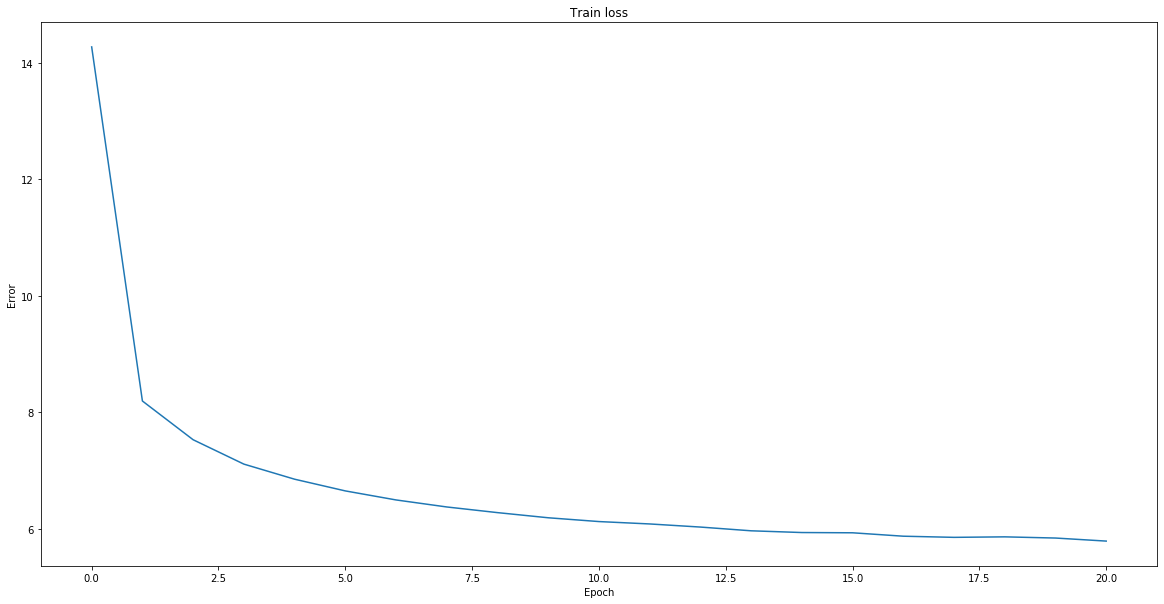

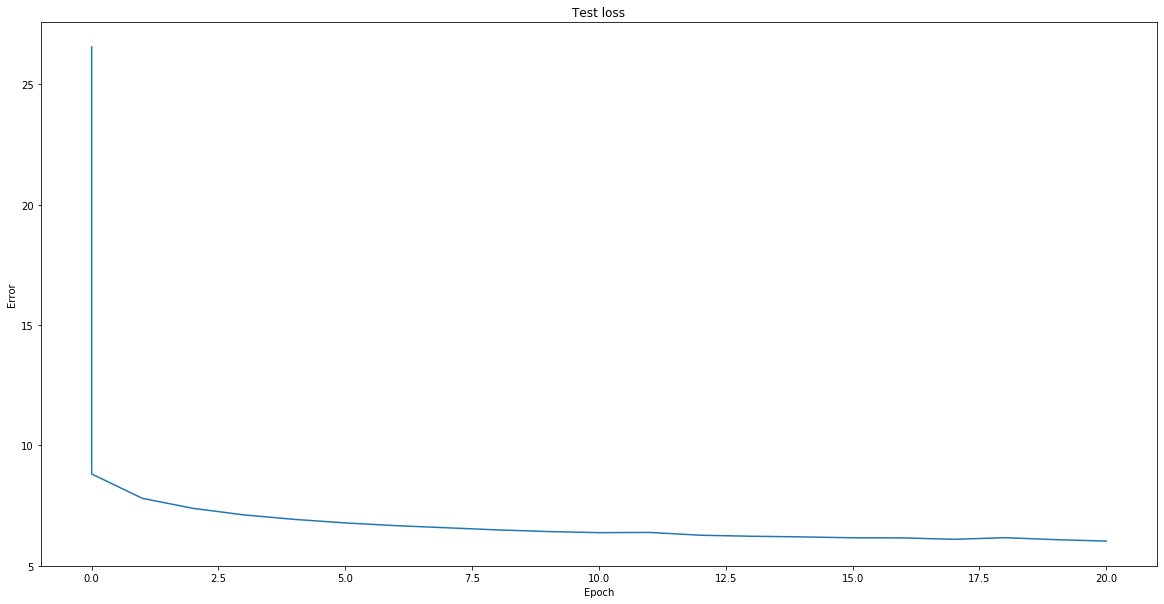

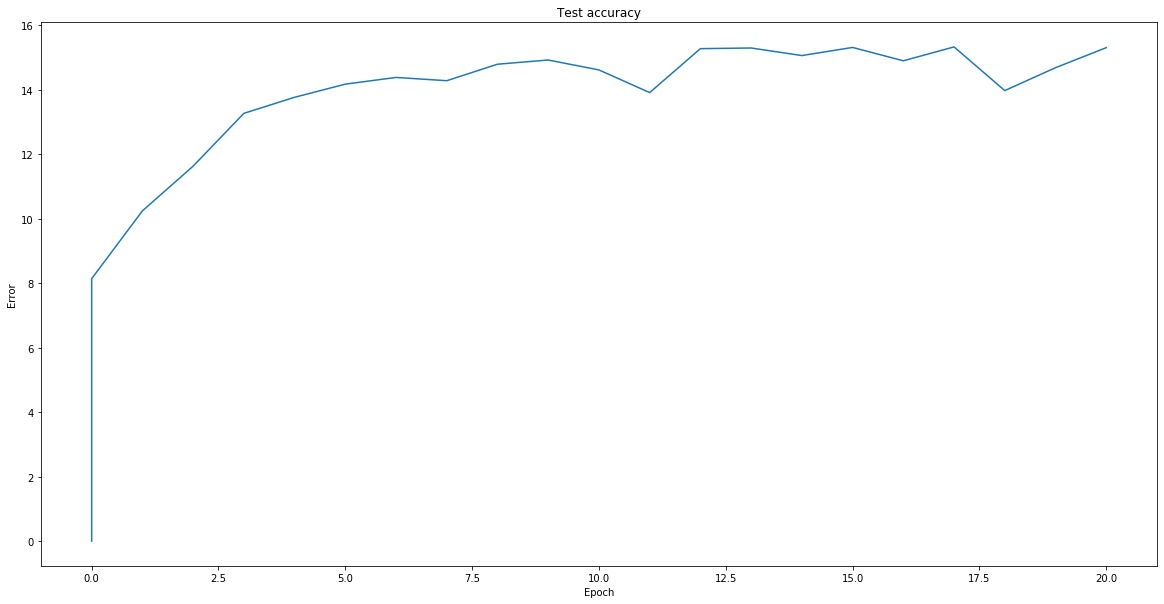

In [16]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 1000
    LOG_PATH = DATA_PATH + 'logs/log.pkl'

    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    #print('train load',train_loader)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)
    print('test load',len(data_test),len(data_train))

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    #start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')
    start_epoch = 0

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter walk into a bar.'
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

## Part 7: Experiments

In [20]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and the <unknown> of the <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <u

#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    2. What was your lowest test perplexity? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. LSTM
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    